In [598]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
#pd.options.display.max_rows = 100
import seaborn as sns 
import indicoio
import sys
sys.path.append("../../Code")
import utils
sys.path.append("../../Tools/python-client")
from __future__ import print_function
import time
from pprint import pprint
import settings as s
import images as im
import cognitive as cog
import files as f
import analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [599]:
reviews = pd.read_csv("../2/nr_restrict_reviews.csv", index_col=0)
listings = pd.read_csv("../2/nr_restrict_listings.csv", index_col=0)

In [600]:
len(reviews)

215960

In [601]:
satisfaction = pd.read_csv("../3/satisfaction_scores.csv", index_col=0)

In [602]:
airbnb = pd.read_csv("../5/airbnb_vocab_final.csv", index_col=0)

In [603]:
def get_motivation_pairing(x):
    if x <0:
        return 'bus-soc'
    elif x> 0:
        return 'soc-bus'
    else:
        return 'no-diff'

In [604]:
airbnb['motivation_pairing'] = airbnb['social_motivation_hg_diff'].map(lambda x: get_motivation_pairing(x))

In [605]:
airbnb.motivation_pairing.value_counts()

bus-soc    102906
soc-bus     81195
no-diff     31859
Name: motivation_pairing, dtype: int64

In [606]:
demo = pd.read_csv("../4/all_demographics.csv", index_col=0)

In [607]:
profiles = pd.read_csv("../5/language_profiles.csv", index_col=0)

In [890]:
profiles_feat = ['cosine_similarity', 'tfidf']

In [952]:
country_cult = pd.read_csv("../7/country_cultural_diff.csv", index_col=0)

In [953]:
country_cult['power_difference'] = np.abs(country_cult['power_difference'])

In [954]:
country_cult['individualism_difference'] = np.abs(country_cult['individualism_difference'])

In [955]:
airbnb_feats = ['social_motivation_sim']#'social_motivation_hg_diff', 

In [956]:
airbnb['social_motivation_sim'] = airbnb['social_motivation_abs_diff'].astype(float)*(-1)

In [957]:
demo_feats = ['age_difference', 'gender_pairing', 'isSameRace']
#'age_difference', 'gender_pairing', 'age-pairing','gender_difference',


In [958]:
cntry_cult = ['same_country', 'power_difference', 'individualism_difference']
#'eng_in_guest_clangs'

In [959]:
cntry_diversity = ['h_min_used', 'h_min_cntry', 'diverse_guests']
demo_diversity = ['age_range', 'gender_proportion_gap']

In [960]:
demo_emotion = ['isSameEmotion', 'smile_distance_absolute']# 'smile_distance', 

In [983]:
all_feats = demo_emotion + demo_diversity + cntry_diversity + cntry_cult + demo_feats + airbnb_feats

In [984]:
final_set = reviews[['id','listing_id', 'reviewer_id', 'recipient_id']].join(listings[['id', 'room_type']].set_index('id'), on='listing_id')[['id', 'room_type', 'recipient_id', 'reviewer_id']]

In [985]:
final_set = final_set.join(demo[['id']+demo_feats+demo_emotion+demo_diversity].set_index('id'), on='id')

In [986]:
final_set = final_set.join(airbnb[['id']+airbnb_feats].set_index('id'), on='id')

In [987]:
final_set = final_set.join(country_cult[['id']+cntry_cult+cntry_diversity].set_index('id'), on='id')

In [988]:
final_set = final_set.join(satisfaction[['id', 'satisfaction', 'relative_satisfaction']].set_index('id'), on='id')

In [989]:
final_set = final_set.join(final_set.groupby('recipient_id').count().rename(columns={'relative_satisfaction':'num_host_reviews'})[['num_host_reviews']], on='recipient_id')

In [990]:
final_set = final_set.dropna()

In [991]:
final_set.describe()

,id,recipient_id,reviewer_id,age_difference,isSameRace,isSameEmotion,smile_distance_absolute,age_range,gender_proportion_gap,social_motivation_sim,same_country,power_difference,individualism_difference,h_min_used,h_min_cntry,diverse_guests,satisfaction,relative_satisfaction,num_host_reviews
count,9.482000e+03,9.482000e+03,9.482000e+03,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000,9482.000000
mean,1.238042e+08,2.371157e+07,4.337361e+07,0.279899,0.714828,0.379245,0.387149,36.078570,0.280282,-0.368050,0.570766,5.877030,10.014870,1.302046,0.713457,0.349820,0.671704,0.000353,79.749842
std,8.096097e+07,3.480625e+07,4.375649e+07,13.115815,0.451520,0.485225,0.417237,14.681143,0.247939,0.298396,0.494993,11.098311,18.103299,2.271540,1.245113,0.209288,0.111876,0.105920,65.909390
min,9.333300e+04,7.989000e+03,4.310000e+02,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.087298,-0.556371,5.000000
25%,5.151840e+07,2.999445e+06,9.380417e+06,-7.000000,0.000000,0.000000,0.000000,26.000000,0.100000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197674,0.606405,-0.055160,28.000000
50%,1.145936e+08,9.363824e+06,2.777601e+07,1.000000,1.000000,0.000000,0.175000,37.000000,0.225806,-0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.291667,0.706108,0.026769,61.000000
75%,1.979831e+08,2.724009e+07,6.362703e+07,8.000000,1.000000,1.000000,0.889000,47.000000,0.375000,-0.102360,1.000000,5.000000,12.000000,2.000000,1.000000,0.437500,0.745360,0.071256,114.000000
max,2.725255e+08,1.875685e+08,1.908363e+08,48.000000,1.000000,1.000000,1.000000,69.000000,1.000000,-0.000000,1.000000,64.000000,85.000000,14.000000,6.000000,1.000000,0.907517,0.303926,320.000000


In [992]:
len(final_set.groupby('recipient_id').count())

1488

In [993]:
len(final_set.groupby('reviewer_id').count())

9162

# Proportion of full vs shared


In [994]:
final_set.room_type.value_counts()

Entire home/apt    5398
Private room       3988
Shared room          96
Name: room_type, dtype: int64

In [995]:
shared_set = final_set[final_set.room_type != 'Entire home/apt']

In [996]:
shared_set = shared_set.drop(['id', 'room_type'], axis=1)

In [1149]:
shared_set[all_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
isSameEmotion,4084.0,0.386876,0.487094,0.000000,0.000000,0.000000,1.000000,1.0
smile_distance_absolute,4084.0,0.380030,0.420228,0.000000,0.000000,0.150000,0.886000,1.0
age_range,4084.0,38.138590,13.850162,0.000000,30.000000,39.000000,48.000000,66.0
gender_proportion_gap,4084.0,0.286755,0.248951,0.000000,0.111111,0.238095,0.375000,1.0
h_min_used,4084.0,1.290402,2.196316,0.000000,0.000000,0.000000,1.000000,7.0
h_min_cntry,4084.0,0.701518,1.148229,0.000000,0.000000,0.000000,1.000000,6.0
diverse_guests,4084.0,0.344004,0.200079,0.105263,0.200000,0.285714,0.421053,1.0
same_country,4084.0,0.529138,0.499211,0.000000,0.000000,1.000000,1.000000,1.0
power_difference,4084.0,6.898629,12.171664,0.000000,0.000000,0.000000,5.000000,64.0
individualism_difference,4084.0,12.211802,20.085074,0.000000,0.000000,0.000000,20.000000,85.0


In [998]:
full_set = final_set[final_set.room_type == 'Entire home/apt']

In [1150]:
full_set[all_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
isSameEmotion,5398.0,0.373472,0.483771,0.000000,0.000000,0.000000,1.000000,1.0
smile_distance_absolute,5398.0,0.392535,0.414917,0.000000,0.001000,0.195500,0.889000,1.0
age_range,5398.0,34.520007,15.095418,0.000000,24.000000,34.000000,46.000000,69.0
gender_proportion_gap,5398.0,0.275385,0.247080,0.000000,0.090909,0.200000,0.375000,1.0
h_min_used,5398.0,1.310856,2.327000,0.000000,0.000000,0.000000,2.000000,14.0
h_min_cntry,5398.0,0.722490,1.313707,0.000000,0.000000,0.000000,1.000000,6.0
diverse_guests,5398.0,0.354220,0.215910,0.066667,0.186916,0.300000,0.454545,1.0
same_country,5398.0,0.602260,0.489477,0.000000,0.000000,1.000000,1.000000,1.0
power_difference,5398.0,5.104113,10.144568,0.000000,0.000000,0.000000,5.000000,64.0
individualism_difference,5398.0,8.352723,16.251762,0.000000,0.000000,0.000000,11.000000,85.0


In [1000]:
full_set = full_set.drop(['id', 'room_type'], axis=1)

In [1001]:
from sklearn import preprocessing
def get_x_y(data, y_col):
    x = data.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled)
    X.columns = data.columns
    return (X.drop(y_col, axis=1), X[y_col])

# All

# Full

### Satisfaction

In [1002]:
full_similarity = full_set[["satisfaction"]+all_feats]

In [1003]:
full_similarity['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [1004]:
full_similarity = analysis.get_dummies(full_similarity, 'gender_pairing')

full_similarity['race_pairing'].value_counts()

full_similarity = analysis.get_dummies(full_similarity, 'race_pairing')

full_similarity['emotion_pairing'].value_counts()

full_similarity = analysis.get_dummies(full_similarity, 'emotion_pairing')

In [1005]:
full_similarity_X,full_similarity_Y = get_x_y(full_similarity, 'satisfaction')

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


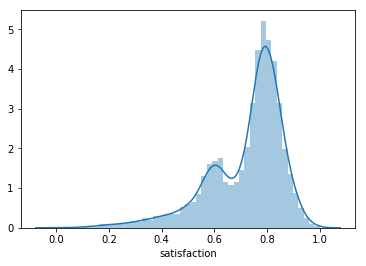

In [1006]:
sns.distplot(full_similarity_Y)
plt.show()

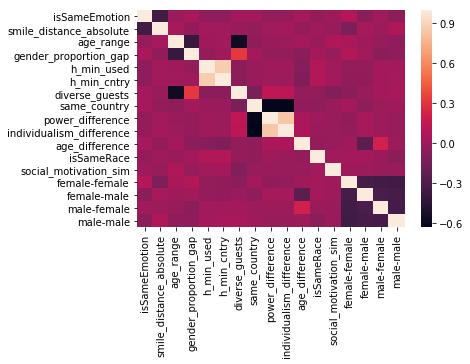

,isSameEmotion,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,isSameRace,social_motivation_sim,female-female,female-male,male-female,male-male
isSameEmotion,1,-0.341631,-0.00947244,0.0442229,-0.044553,-0.041557,0.0363887,0.0249172,-0.027104,-0.022933,0.0394067,-0.0205361,0.00743705,0.0973199,-0.0629716,0.0197111,-0.056923
smile_distance_absolute,-0.341631,1,0.0384128,-0.0360446,0.0255207,0.0179695,-0.00749008,-0.0295669,0.0222245,0.0254063,-0.0234727,0.014553,-0.00997333,-0.111455,0.0387875,-0.000919422,0.0759487
age_range,-0.00947244,0.0384128,1,-0.390266,0.00770346,0.0210036,-0.56277,-0.0429951,-0.00581412,0.00480269,0.0251574,-0.00295168,0.0691281,0.0543312,0.00786038,-0.0185945,-0.0440409
gender_proportion_gap,0.0442229,-0.0360446,-0.390266,1,-0.022743,0.00762133,0.321972,0.0283333,-0.0207682,-0.0227998,-0.057779,0.0254243,-0.0169677,0.0821179,0.0220759,-0.0646065,-0.0405037
h_min_used,-0.044553,0.0255207,0.00770346,-0.022743,1,0.860597,-0.0580517,-0.00644068,0.00767873,0.0110294,-0.0777247,0.0836741,0.0222829,-0.0222083,-0.0240919,0.0212968,0.0246124
h_min_cntry,-0.041557,0.0179695,0.0210036,0.00762133,0.860597,1,-0.0624884,-0.00426875,-0.001085,0.00232915,-0.0997481,0.0847352,0.0246749,-0.0350127,-0.0341865,0.0267734,0.0418374
diverse_guests,0.0363887,-0.00749008,-0.56277,0.321972,-0.0580517,-0.0624884,1,-0.119077,0.134862,0.125801,-0.0274164,-0.0234973,-0.0926732,-0.0654105,-0.00939027,0.028922,0.0465311
same_country,0.0249172,-0.0295669,-0.0429951,0.0283333,-0.00644068,-0.00426875,-0.119077,1,-0.619184,-0.6325,-0.0353258,-0.0438185,-0.0126567,0.0287759,-0.0446016,0.0044023,0.00953914
power_difference,-0.027104,0.0222245,-0.00581412,-0.0207682,0.00767873,-0.001085,0.134862,-0.619184,1,0.834325,0.0482208,0.00733643,-0.0136884,-0.03438,0.0422339,0.00246348,-0.00836074
individualism_difference,-0.022933,0.0254063,0.00480269,-0.0227998,0.0110294,0.00232915,0.125801,-0.6325,0.834325,1,0.0664826,-0.00166377,-0.00860688,-0.0288201,0.0413095,0.00144743,-0.0120774


                        cols        vif
0              isSameEmotion   1.145885
1    smile_distance_absolute   1.145535
2                  age_range   1.614711
3      gender_proportion_gap   1.239070
4                 h_min_used   3.888534
5                h_min_cntry   3.920871
6             diverse_guests   1.575563
7               same_country   1.775620
8           power_difference   3.459159
9   individualism_difference   3.559193
10            age_difference   1.112463
11                isSameRace   1.017694
12     social_motivation_sim   1.011357
13             female-female  15.698894
14               female-male  12.634409
15               male-female  15.209333
16                 male-male  15.003014
dropping 'female-female' at index: 13
                        cols        vif
0              isSameEmotion   1.798839
1    smile_distance_absolute   2.132928
2                  age_range   6.987690
3      gender_proportion_gap   2.595058
4                 h_min_used   5.113380
5 

In [1008]:
analysis.test_features(full_similarity_X, full_similarity_Y, vif_thresh=10)

### Relative Satisfaction

In [1009]:
full_similarity = full_set[["relative_satisfaction"]+all_feats]

In [1010]:
full_similarity['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [1011]:
full_similarity = analysis.get_dummies(full_similarity, 'gender_pairing')

In [1012]:
full_similarity_X,full_similarity_Y = get_x_y(full_similarity, 'relative_satisfaction')

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


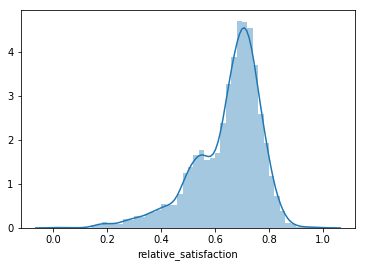

In [1013]:
sns.distplot(full_similarity_Y)
plt.show()

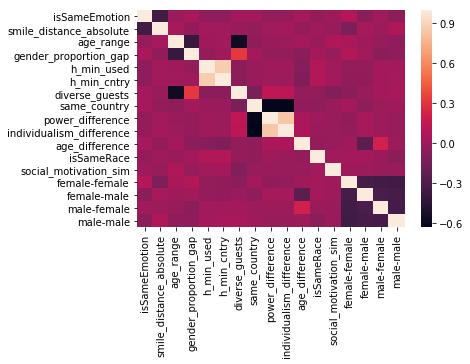

,isSameEmotion,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,isSameRace,social_motivation_sim,female-female,female-male,male-female,male-male
isSameEmotion,1,-0.341631,-0.00947244,0.0442229,-0.044553,-0.041557,0.0363887,0.0249172,-0.027104,-0.022933,0.0394067,-0.0205361,0.00743705,0.0973199,-0.0629716,0.0197111,-0.056923
smile_distance_absolute,-0.341631,1,0.0384128,-0.0360446,0.0255207,0.0179695,-0.00749008,-0.0295669,0.0222245,0.0254063,-0.0234727,0.014553,-0.00997333,-0.111455,0.0387875,-0.000919422,0.0759487
age_range,-0.00947244,0.0384128,1,-0.390266,0.00770346,0.0210036,-0.56277,-0.0429951,-0.00581412,0.00480269,0.0251574,-0.00295168,0.0691281,0.0543312,0.00786038,-0.0185945,-0.0440409
gender_proportion_gap,0.0442229,-0.0360446,-0.390266,1,-0.022743,0.00762133,0.321972,0.0283333,-0.0207682,-0.0227998,-0.057779,0.0254243,-0.0169677,0.0821179,0.0220759,-0.0646065,-0.0405037
h_min_used,-0.044553,0.0255207,0.00770346,-0.022743,1,0.860597,-0.0580517,-0.00644068,0.00767873,0.0110294,-0.0777247,0.0836741,0.0222829,-0.0222083,-0.0240919,0.0212968,0.0246124
h_min_cntry,-0.041557,0.0179695,0.0210036,0.00762133,0.860597,1,-0.0624884,-0.00426875,-0.001085,0.00232915,-0.0997481,0.0847352,0.0246749,-0.0350127,-0.0341865,0.0267734,0.0418374
diverse_guests,0.0363887,-0.00749008,-0.56277,0.321972,-0.0580517,-0.0624884,1,-0.119077,0.134862,0.125801,-0.0274164,-0.0234973,-0.0926732,-0.0654105,-0.00939027,0.028922,0.0465311
same_country,0.0249172,-0.0295669,-0.0429951,0.0283333,-0.00644068,-0.00426875,-0.119077,1,-0.619184,-0.6325,-0.0353258,-0.0438185,-0.0126567,0.0287759,-0.0446016,0.0044023,0.00953914
power_difference,-0.027104,0.0222245,-0.00581412,-0.0207682,0.00767873,-0.001085,0.134862,-0.619184,1,0.834325,0.0482208,0.00733643,-0.0136884,-0.03438,0.0422339,0.00246348,-0.00836074
individualism_difference,-0.022933,0.0254063,0.00480269,-0.0227998,0.0110294,0.00232915,0.125801,-0.6325,0.834325,1,0.0664826,-0.00166377,-0.00860688,-0.0288201,0.0413095,0.00144743,-0.0120774


                        cols        vif
0              isSameEmotion   1.145885
1    smile_distance_absolute   1.145535
2                  age_range   1.614711
3      gender_proportion_gap   1.239070
4                 h_min_used   3.888534
5                h_min_cntry   3.920871
6             diverse_guests   1.575563
7               same_country   1.775620
8           power_difference   3.459159
9   individualism_difference   3.559193
10            age_difference   1.112463
11                isSameRace   1.017694
12     social_motivation_sim   1.011357
13             female-female  15.698894
14               female-male  12.634409
15               male-female  15.209333
16                 male-male  15.003014
dropping 'female-female' at index: 13
                        cols        vif
0              isSameEmotion   1.798839
1    smile_distance_absolute   2.132928
2                  age_range   6.987690
3      gender_proportion_gap   2.595058
4                 h_min_used   5.113380
5 

In [1014]:
analysis.test_features(full_similarity_X, full_similarity_Y, vif_thresh=10)

# Shared

### Satisfaction

In [1015]:
shared_similarity = shared_set[["satisfaction"]+all_feats]

shared_similarity['motivation_pairing'].value_counts()

shared_similarity = analysis.get_dummies(shared_similarity, 'motivation_pairing')

In [1016]:
shared_similarity['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [1017]:
shared_similarity = analysis.get_dummies(shared_similarity, 'gender_pairing')

In [1018]:
shared_similarity_X,shared_similarity_Y = get_x_y(shared_similarity, 'satisfaction')

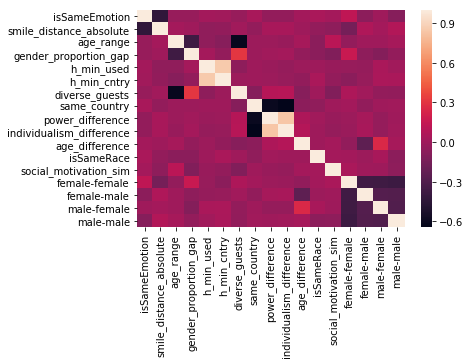

,isSameEmotion,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,isSameRace,social_motivation_sim,female-female,female-male,male-female,male-male
isSameEmotion,1,-0.434173,-0.0254117,-0.0265485,0.0206421,0.0169037,-0.0272006,0.0422646,-0.0344458,-0.037943,0.0202123,0.0451566,0.0251608,0.132065,-0.0642775,0.00436557,-0.0878329
smile_distance_absolute,-0.434173,1,0.0291371,0.00764499,-0.0507406,-0.0441937,0.011826,-0.0387168,0.0403316,0.0420344,0.00177994,-0.0365218,-0.0539717,-0.152087,0.068093,0.0243922,0.077891
age_range,-0.0254117,0.0291371,1,-0.369358,-0.0502839,-0.0838571,-0.616194,-0.00635809,-0.0023545,-0.0170212,0.0334509,-0.070324,0.113295,-0.0388839,0.00761553,0.00458026,0.0311426
gender_proportion_gap,-0.0265485,0.00764499,-0.369358,1,0.0262765,-0.0349822,0.311549,-0.00620654,0.0155371,0.0268937,-0.0356308,-0.0668812,-0.107237,0.170677,-0.0574106,-0.0953105,-0.0389066
h_min_used,0.0206421,-0.0507406,-0.0502839,0.0262765,1,0.854439,-0.0549179,0.00411959,-0.0148124,-0.0330191,-0.00706976,0.00222406,-0.0195195,-0.0276388,-0.0306369,0.0457082,0.0155024
h_min_cntry,0.0169037,-0.0441937,-0.0838571,-0.0349822,0.854439,1,-0.00380879,-0.00212811,-0.00586315,-0.0255069,-0.0442543,0.0486412,-0.0377804,-0.0684169,-0.0227752,0.0503177,0.048476
diverse_guests,-0.0272006,0.011826,-0.616194,0.311549,-0.0549179,-0.00380879,1,-0.0867879,0.0892798,0.097259,-0.0816396,0.0098612,-0.110673,0.0617579,0.0131106,-0.0382798,-0.0435179
same_country,0.0422646,-0.0387168,-0.00635809,-0.00620654,0.00411959,-0.00212811,-0.0867879,1,-0.600902,-0.64461,-0.0626566,-0.0477656,0.00787056,0.0202848,-0.0427665,0.00742033,0.0120573
power_difference,-0.0344458,0.0403316,-0.0023545,0.0155371,-0.0148124,-0.00586315,0.0892798,-0.600902,1,0.837041,0.060276,0.0113258,-0.0178927,-0.00350532,0.0309272,-0.032035,0.00524684
individualism_difference,-0.037943,0.0420344,-0.0170212,0.0268937,-0.0330191,-0.0255069,0.097259,-0.64461,0.837041,1,0.0854186,0.00275544,-0.0282647,-0.0148899,0.0365523,-0.032271,0.0125975


                        cols        vif
0              isSameEmotion   1.248658
1    smile_distance_absolute   1.254391
2                  age_range   1.777043
3      gender_proportion_gap   1.255548
4                 h_min_used   3.873150
5                h_min_cntry   3.911392
6             diverse_guests   1.709937
7               same_country   1.766454
8           power_difference   3.424071
9   individualism_difference   3.768818
10            age_difference   1.140069
11                isSameRace   1.033603
12     social_motivation_sim   1.031927
13             female-female  21.156932
14               female-male  13.391300
15               male-female  15.420525
16                 male-male  15.051781
dropping 'female-female' at index: 13
                        cols        vif
0              isSameEmotion   1.958766
1    smile_distance_absolute   2.229148
2                  age_range   8.755201
3      gender_proportion_gap   2.607070
4                 h_min_used   5.210185
5 

In [1019]:
analysis.test_features(shared_similarity_X, shared_similarity_Y, vif_thresh=10)

### Relative Satisfaction

In [1020]:
shared_similarity = shared_set[["relative_satisfaction"]+all_feats]

shared_similarity['motivation_pairing'].value_counts()

shared_similarity = analysis.get_dummies(shared_similarity, 'motivation_pairing')

In [1021]:
shared_similarity['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [658]:
shared_similarity = analysis.get_dummies(shared_similarity, 'gender_pairing')

In [659]:
shared_similarity_X,shared_similarity_Y = get_x_y(shared_similarity, 'relative_satisfaction')

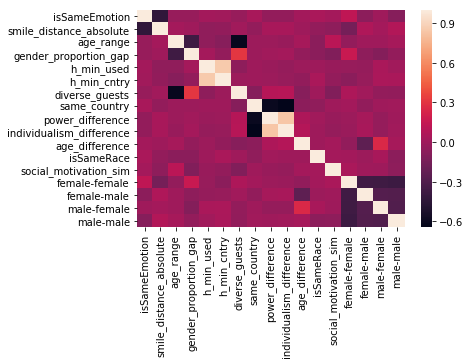

,isSameEmotion,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,isSameRace,social_motivation_sim,female-female,female-male,male-female,male-male
isSameEmotion,1,-0.434173,-0.0254117,-0.0265485,0.0206421,0.0169037,-0.0272006,0.0422646,-0.0344458,-0.037943,0.0202123,0.0451566,0.0251608,0.132065,-0.0642775,0.00436557,-0.0878329
smile_distance_absolute,-0.434173,1,0.0291371,0.00764499,-0.0507406,-0.0441937,0.011826,-0.0387168,0.0403316,0.0420344,0.00177994,-0.0365218,-0.0539717,-0.152087,0.068093,0.0243922,0.077891
age_range,-0.0254117,0.0291371,1,-0.369358,-0.0502839,-0.0838571,-0.616194,-0.00635809,-0.0023545,-0.0170212,0.0334509,-0.070324,0.113295,-0.0388839,0.00761553,0.00458026,0.0311426
gender_proportion_gap,-0.0265485,0.00764499,-0.369358,1,0.0262765,-0.0349822,0.311549,-0.00620654,0.0155371,0.0268937,-0.0356308,-0.0668812,-0.107237,0.170677,-0.0574106,-0.0953105,-0.0389066
h_min_used,0.0206421,-0.0507406,-0.0502839,0.0262765,1,0.854439,-0.0549179,0.00411959,-0.0148124,-0.0330191,-0.00706976,0.00222406,-0.0195195,-0.0276388,-0.0306369,0.0457082,0.0155024
h_min_cntry,0.0169037,-0.0441937,-0.0838571,-0.0349822,0.854439,1,-0.00380879,-0.00212811,-0.00586315,-0.0255069,-0.0442543,0.0486412,-0.0377804,-0.0684169,-0.0227752,0.0503177,0.048476
diverse_guests,-0.0272006,0.011826,-0.616194,0.311549,-0.0549179,-0.00380879,1,-0.0867879,0.0892798,0.097259,-0.0816396,0.0098612,-0.110673,0.0617579,0.0131106,-0.0382798,-0.0435179
same_country,0.0422646,-0.0387168,-0.00635809,-0.00620654,0.00411959,-0.00212811,-0.0867879,1,-0.600902,-0.64461,-0.0626566,-0.0477656,0.00787056,0.0202848,-0.0427665,0.00742033,0.0120573
power_difference,-0.0344458,0.0403316,-0.0023545,0.0155371,-0.0148124,-0.00586315,0.0892798,-0.600902,1,0.837041,0.060276,0.0113258,-0.0178927,-0.00350532,0.0309272,-0.032035,0.00524684
individualism_difference,-0.037943,0.0420344,-0.0170212,0.0268937,-0.0330191,-0.0255069,0.097259,-0.64461,0.837041,1,0.0854186,0.00275544,-0.0282647,-0.0148899,0.0365523,-0.032271,0.0125975


                        cols        vif
0              isSameEmotion   1.248658
1    smile_distance_absolute   1.254391
2                  age_range   1.777043
3      gender_proportion_gap   1.255548
4                 h_min_used   3.873150
5                h_min_cntry   3.911392
6             diverse_guests   1.709937
7               same_country   1.766454
8           power_difference   3.424071
9   individualism_difference   3.768818
10            age_difference   1.140069
11                isSameRace   1.033603
12     social_motivation_sim   1.031927
13             female-female  21.156932
14               female-male  13.391300
15               male-female  15.420525
16                 male-male  15.051781
dropping 'female-female' at index: 13
                        cols        vif
0              isSameEmotion   1.958766
1    smile_distance_absolute   2.229148
2                  age_range   8.755201
3      gender_proportion_gap   2.607070
4                 h_min_used   5.210185
5 

In [1022]:
analysis.test_features(shared_similarity_X, shared_similarity_Y, vif_thresh=10)

# Profile Emotion

# Full

### Satisfaction

In [1023]:
full_emotion = full_set[["satisfaction"]+demo_emotion]

In [1024]:
full_emotion_X,full_emotion_Y = get_x_y(full_emotion, 'satisfaction')

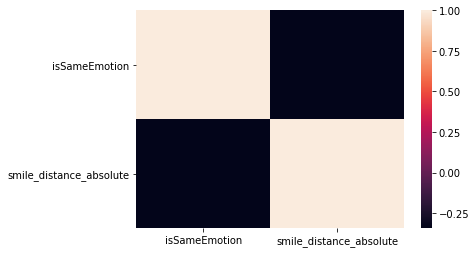

,isSameEmotion,smile_distance_absolute
isSameEmotion,1,-0.341631
smile_distance_absolute,-0.341631,1


                      cols      vif
0            isSameEmotion  1.05262
1  smile_distance_absolute  1.05262
Remaining variables:
Index(['isSameEmotion', 'smile_distance_absolute'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     5287.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:15:10   Log-Likelihood:                -3071.2
No. Observations:                5398   AIC:                             6146.
Df Residuals:                    5396   BIC:                             6160.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
             

In [1025]:
analysis.test_features(full_emotion_X, full_emotion_Y, vif_thresh=10)

### Relative Satisfaction

In [1127]:
full_emotion = full_set[["relative_satisfaction"]+demo_emotion]

In [1128]:
full_emotion_X,full_emotion_Y = get_x_y(full_emotion, 'relative_satisfaction')

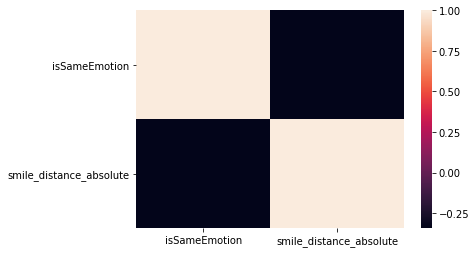

,isSameEmotion,smile_distance_absolute
isSameEmotion,1,-0.341631
smile_distance_absolute,-0.341631,1


                      cols      vif
0            isSameEmotion  1.05262
1  smile_distance_absolute  1.05262
Remaining variables:
Index(['isSameEmotion', 'smile_distance_absolute'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.665
Model:                               OLS   Adj. R-squared:                  0.665
Method:                    Least Squares   F-statistic:                     5358.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:49:37   Log-Likelihood:                -2457.7
No. Observations:                   5398   AIC:                             4919.
Df Residuals:                       5396   BIC:                             4933.
Df Model:                              2                                         
Covariance Type:               nonrobust                         

In [1129]:
analysis.test_features(full_emotion_X, full_emotion_Y, vif_thresh=10)

# Shared

### Satisfaction

In [1029]:
shared_emotion = shared_set[["satisfaction"]+demo_emotion]

In [1030]:
shared_emotion_X,shared_emotion_Y = get_x_y(shared_emotion, 'satisfaction')

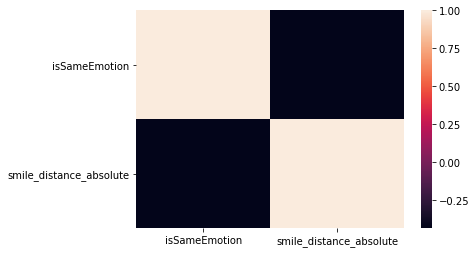

,isSameEmotion,smile_distance_absolute
isSameEmotion,1,-0.434173
smile_distance_absolute,-0.434173,1


                      cols       vif
0            isSameEmotion  1.028018
1  smile_distance_absolute  1.028018
Remaining variables:
Index(['isSameEmotion', 'smile_distance_absolute'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     4694.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:15:25   Log-Likelihood:                -2059.3
No. Observations:                4084   AIC:                             4123.
Df Residuals:                    4082   BIC:                             4135.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
          

In [1031]:
analysis.test_features(shared_emotion_X, shared_emotion_Y, vif_thresh=10)

### Relative Satisfaction

In [1032]:
shared_emotion = shared_set[["relative_satisfaction"]+demo_emotion]

In [1033]:
shared_emotion_X,shared_emotion_Y = get_x_y(shared_emotion, 'relative_satisfaction')

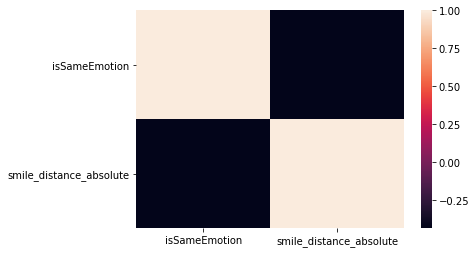

,isSameEmotion,smile_distance_absolute
isSameEmotion,1,-0.434173
smile_distance_absolute,-0.434173,1


                      cols       vif
0            isSameEmotion  1.028018
1  smile_distance_absolute  1.028018
Remaining variables:
Index(['isSameEmotion', 'smile_distance_absolute'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.696
Model:                               OLS   Adj. R-squared:                  0.696
Method:                    Least Squares   F-statistic:                     4666.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:15:32   Log-Likelihood:                -1938.9
No. Observations:                   4084   AIC:                             3882.
Df Residuals:                       4082   BIC:                             3895.
Df Model:                              2                                         
Covariance Type:               nonrobust                      

In [1034]:
analysis.test_features(shared_emotion_X, shared_emotion_Y, vif_thresh=10)

# Motivation

# Full

### Satisfaction

In [1040]:
full_mot= full_set[["satisfaction"]+airbnb_feats+cntry_diversity+demo_diversity]

In [1041]:
full_mot_X,full_mot_Y = get_x_y(full_mot, 'satisfaction')

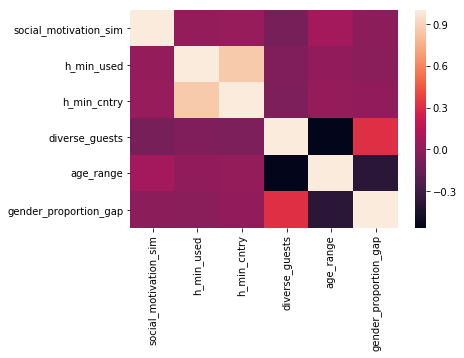

,social_motivation_sim,h_min_used,h_min_cntry,diverse_guests,age_range,gender_proportion_gap
social_motivation_sim,1,0.0222829,0.0246749,-0.0926732,0.0691281,-0.0169677
h_min_used,0.0222829,1,0.860597,-0.0580517,0.00770346,-0.022743
h_min_cntry,0.0246749,0.860597,1,-0.0624884,0.0210036,0.00762133
diverse_guests,-0.0926732,-0.0580517,-0.0624884,1,-0.56277,0.321972
age_range,0.0691281,0.00770346,0.0210036,-0.56277,1,-0.390266
gender_proportion_gap,-0.0169677,-0.022743,0.00762133,0.321972,-0.390266,1


                    cols       vif
0  social_motivation_sim  4.426805
1             h_min_used  5.072248
2            h_min_cntry  5.052404
3         diverse_guests  2.553943
4              age_range  3.452787
5  gender_proportion_gap  2.374761
Remaining variables:
Index(['social_motivation_sim', 'h_min_used', 'h_min_cntry', 'diverse_guests',
       'age_range', 'gender_proportion_gap'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.048e+04
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:18:26   Log-Likelihood:                 852.06
No. Observations:                5398   AIC:                            -1692.
Df Residuals:                    5

In [1042]:
analysis.test_features(full_mot_X, full_mot_Y, vif_thresh=10)

### Relative Satisfaction

In [1043]:
full_mot = full_set[["relative_satisfaction"]+airbnb_feats+cntry_diversity+demo_diversity]

In [1044]:
airbnb_feat_X,airbnb_feat_Y = get_x_y(full_mot, 'relative_satisfaction')

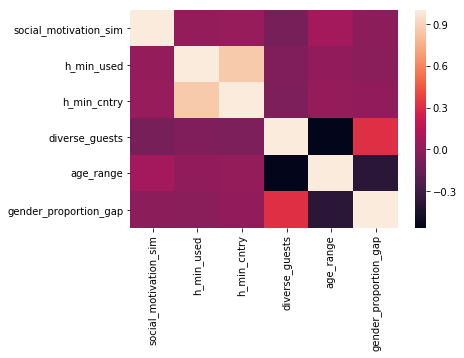

,social_motivation_sim,h_min_used,h_min_cntry,diverse_guests,age_range,gender_proportion_gap
social_motivation_sim,1,0.0222829,0.0246749,-0.0926732,0.0691281,-0.0169677
h_min_used,0.0222829,1,0.860597,-0.0580517,0.00770346,-0.022743
h_min_cntry,0.0246749,0.860597,1,-0.0624884,0.0210036,0.00762133
diverse_guests,-0.0926732,-0.0580517,-0.0624884,1,-0.56277,0.321972
age_range,0.0691281,0.00770346,0.0210036,-0.56277,1,-0.390266
gender_proportion_gap,-0.0169677,-0.022743,0.00762133,0.321972,-0.390266,1


                    cols       vif
0  social_motivation_sim  4.426805
1             h_min_used  5.072248
2            h_min_cntry  5.052404
3         diverse_guests  2.553943
4              age_range  3.452787
5  gender_proportion_gap  2.374761
Remaining variables:
Index(['social_motivation_sim', 'h_min_used', 'h_min_cntry', 'diverse_guests',
       'age_range', 'gender_proportion_gap'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.048e+04
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:18:34   Log-Likelihood:                 852.06
No. Observations:                5398   AIC:                            -1692.
Df Residuals:                    5

In [1045]:
analysis.test_features(full_mot_X, full_mot_Y, vif_thresh=10)

# Shared

### Satisfaction

In [1046]:
shared_mot = shared_set[["satisfaction"]+airbnb_feats+cntry_diversity+demo_diversity]

In [1049]:
shared_mot_X,shared_mot_Y = get_x_y(shared_mot, 'satisfaction')

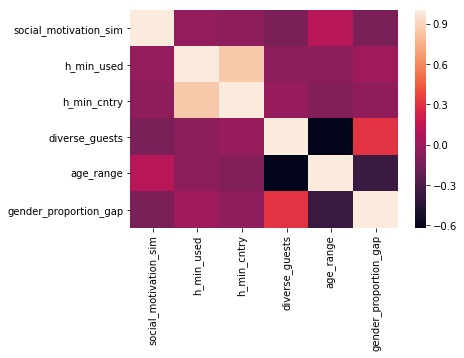

,social_motivation_sim,h_min_used,h_min_cntry,diverse_guests,age_range,gender_proportion_gap
social_motivation_sim,1,-0.0195195,-0.0377804,-0.110673,0.113295,-0.107237
h_min_used,-0.0195195,1,0.854439,-0.0549179,-0.0502839,0.0262765
h_min_cntry,-0.0377804,0.854439,1,-0.00380879,-0.0838571,-0.0349822
diverse_guests,-0.110673,-0.0549179,-0.00380879,1,-0.616194,0.311549
age_range,0.113295,-0.0502839,-0.0838571,-0.616194,1,-0.369358
gender_proportion_gap,-0.107237,0.0262765,-0.0349822,0.311549,-0.369358,1


                    cols       vif
0  social_motivation_sim  4.925373
1             h_min_used  5.148732
2            h_min_cntry  5.196176
3         diverse_guests  2.435445
4              age_range  4.312475
5  gender_proportion_gap  2.422583
Remaining variables:
Index(['social_motivation_sim', 'h_min_used', 'h_min_cntry', 'diverse_guests',
       'age_range', 'gender_proportion_gap'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:18:47   Log-Likelihood:                 1214.1
No. Observations:                4084   AIC:                            -2416.
Df Residuals:                    4

In [1050]:
analysis.test_features(shared_mot_X, shared_mot_Y, vif_thresh=10)

### Relative Satisfaction

In [1051]:
shared_mot = shared_set[["relative_satisfaction"]+airbnb_feats+cntry_diversity+demo_diversity]

In [1054]:
shared_mot_X,shared_mot_Y = get_x_y(shared_mot, 'relative_satisfaction')

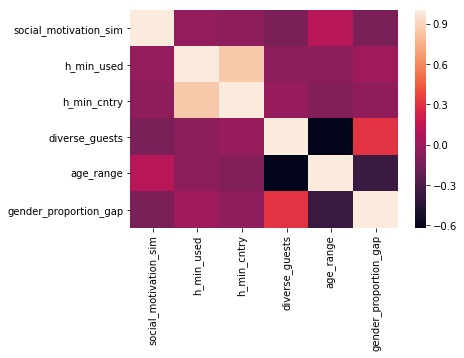

,social_motivation_sim,h_min_used,h_min_cntry,diverse_guests,age_range,gender_proportion_gap
social_motivation_sim,1,-0.0195195,-0.0377804,-0.110673,0.113295,-0.107237
h_min_used,-0.0195195,1,0.854439,-0.0549179,-0.0502839,0.0262765
h_min_cntry,-0.0377804,0.854439,1,-0.00380879,-0.0838571,-0.0349822
diverse_guests,-0.110673,-0.0549179,-0.00380879,1,-0.616194,0.311549
age_range,0.113295,-0.0502839,-0.0838571,-0.616194,1,-0.369358
gender_proportion_gap,-0.107237,0.0262765,-0.0349822,0.311549,-0.369358,1


                    cols       vif
0  social_motivation_sim  4.925373
1             h_min_used  5.148732
2            h_min_cntry  5.196176
3         diverse_guests  2.435445
4              age_range  4.312475
5  gender_proportion_gap  2.422583
Remaining variables:
Index(['social_motivation_sim', 'h_min_used', 'h_min_cntry', 'diverse_guests',
       'age_range', 'gender_proportion_gap'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.936
Model:                               OLS   Adj. R-squared:                  0.936
Method:                    Least Squares   F-statistic:                     9994.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:19:25   Log-Likelihood:                 1255.2
No. Observations:                   4084   AIC:                            -2498.
Df Residuals:

In [1056]:
analysis.test_features(shared_mot_X, shared_mot_Y, vif_thresh=10)

# Country_culture

# Full

### Satisfaction

In [1057]:
full_cntry = full_set[["satisfaction"]+cntry_cult]

In [1058]:
full_cntry_X,full_cntry_Y = get_x_y(full_cntry, 'satisfaction')

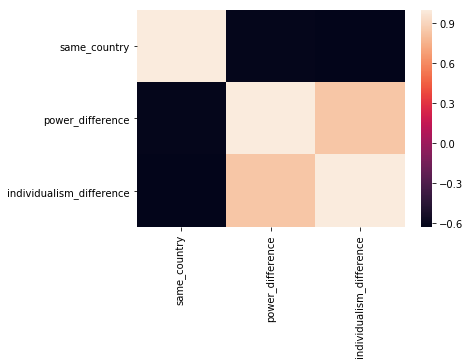

,same_country,power_difference,individualism_difference
same_country,1,-0.619184,-0.6325
power_difference,-0.619184,1,0.834325
individualism_difference,-0.6325,0.834325,1


                       cols     vif
0              same_country  1.0000
1          power_difference  4.0652
2  individualism_difference  4.0652
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     6623.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:19:39   Log-Likelihood:                -1833.0
No. Observations:                5398   AIC:                             3672.
Df Residuals:                    5395   BIC:                             3692.
Df Model:                           3                                         
Covariance Type:            nonrobus

In [1059]:
analysis.test_features(full_cntry_X, full_cntry_Y, vif_thresh=10)

### Relative Satisfaction

In [1060]:
full_cntry = full_set[["relative_satisfaction"]+cntry_cult]

In [1061]:
cntry_cult_X,cntry_cult_Y = get_x_y(full_cntry, 'relative_satisfaction')

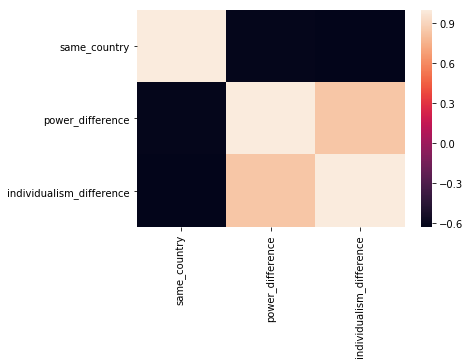

,same_country,power_difference,individualism_difference
same_country,1,-0.619184,-0.6325
power_difference,-0.619184,1,0.834325
individualism_difference,-0.6325,0.834325,1


                       cols     vif
0              same_country  1.0000
1          power_difference  4.0652
2  individualism_difference  4.0652
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     6623.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:19:48   Log-Likelihood:                -1833.0
No. Observations:                5398   AIC:                             3672.
Df Residuals:                    5395   BIC:                             3692.
Df Model:                           3                                         
Covariance Type:            nonrobus

In [1062]:
analysis.test_features(full_cntry_X, full_cntry_Y, vif_thresh=10)

# Shared

### Satisfaction

In [1063]:
shared_cntry = shared_set[["satisfaction"]+cntry_cult]

In [1064]:
shared_cntry_X,shared_cntry_Y = get_x_y(shared_cntry, 'satisfaction')

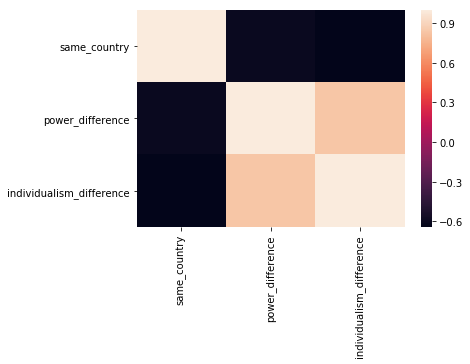

,same_country,power_difference,individualism_difference
same_country,1,-0.600902,-0.64461
power_difference,-0.600902,1,0.837041
individualism_difference,-0.64461,0.837041,1


                       cols       vif
0              same_country  1.000000
1          power_difference  4.378019
2  individualism_difference  4.378019
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     4643.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:19:56   Log-Likelihood:                -1465.8
No. Observations:                4084   AIC:                             2938.
Df Residuals:                    4081   BIC:                             2957.
Df Model:                           3                                         
Covariance Type:            

In [1065]:
analysis.test_features(shared_cntry_X, shared_cntry_Y, vif_thresh=10)

### Relative Satisfaction

In [1066]:
shared_cntry = shared_set[["relative_satisfaction"]+cntry_cult]

In [1067]:
shared_cntry_X,shared_cntry_Y = get_x_y(shared_cntry, 'relative_satisfaction')

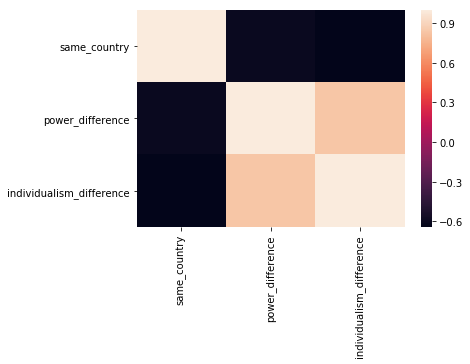

,same_country,power_difference,individualism_difference
same_country,1,-0.600902,-0.64461
power_difference,-0.600902,1,0.837041
individualism_difference,-0.64461,0.837041,1


                       cols       vif
0              same_country  1.000000
1          power_difference  4.378019
2  individualism_difference  4.378019
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.775
Model:                               OLS   Adj. R-squared:                  0.775
Method:                    Least Squares   F-statistic:                     4684.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:20:05   Log-Likelihood:                -1322.8
No. Observations:                   4084   AIC:                             2652.
Df Residuals:                       4081   BIC:                             2671.
Df Model:                              3                                         
C

In [1068]:
analysis.test_features(shared_cntry_X, shared_cntry_Y, vif_thresh=10)

# Demographics

# Full

### Satisfaction

In [1104]:
full_demo = full_set[["satisfaction"]+demo_feats]

In [1105]:
full_demo['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [1106]:
full_demo = analysis.get_dummies(full_demo, 'gender_pairing')

full_demo['age-pairing'].value_counts()

full_demo = analysis.get_dummies(full_demo, 'age-pairing')

In [1107]:
full_demo_X,full_demo_Y = get_x_y(full_demo, 'satisfaction')

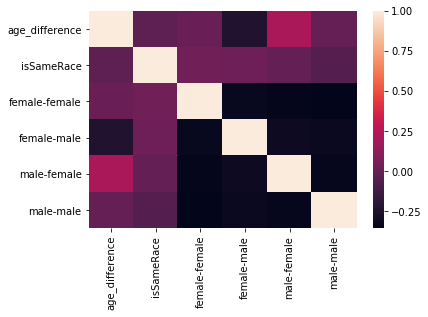

,age_difference,isSameRace,female-female,female-male,male-female,male-male
age_difference,1,-0.0232071,0.0107637,-0.23713,0.217227,0.00364138
isSameRace,-0.0232071,1,0.0331864,0.0265567,-0.00440089,-0.054643
female-female,0.0107637,0.0331864,1,-0.328659,-0.342725,-0.355237
female-male,-0.23713,0.0265567,-0.328659,1,-0.311961,-0.323351
male-female,0.217227,-0.00440089,-0.342725,-0.311961,1,-0.33719
male-male,0.00364138,-0.054643,-0.355237,-0.323351,-0.33719,1


             cols       vif
0  age_difference  1.086128
1      isSameRace  1.003937
2   female-female  6.616777
3     female-male  4.996101
4     male-female  6.969846
5       male-male  6.324266
dropping 'male-female' at index: 4
             cols       vif
0  age_difference  4.531382
1      isSameRace  3.370498
2   female-female  1.813733
3     female-male  1.595847
4       male-male  1.764494
Remaining variables:
Index(['age_difference', 'isSameRace', 'female-female', 'female-male',
       'male-male'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.499e+04
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:24:00   Log-Likelihood:                

In [1108]:
analysis.test_features(full_demo_X, full_demo_Y, vif_thresh=5)

### Relative Satisfaction

In [1109]:
full_demo = full_set[["relative_satisfaction"]+demo_feats]

In [1110]:
full_demo['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [1111]:
full_demo = analysis.get_dummies(full_demo, 'gender_pairing')

In [1112]:
full_demo_X,full_demo_Y = get_x_y(full_demo, 'relative_satisfaction')

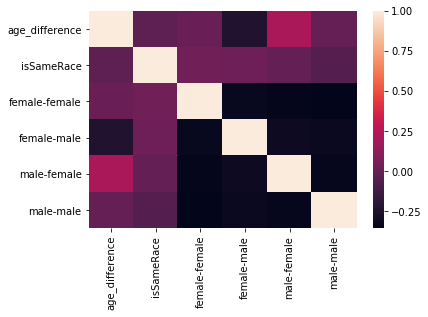

,age_difference,isSameRace,female-female,female-male,male-female,male-male
age_difference,1,-0.0232071,0.0107637,-0.23713,0.217227,0.00364138
isSameRace,-0.0232071,1,0.0331864,0.0265567,-0.00440089,-0.054643
female-female,0.0107637,0.0331864,1,-0.328659,-0.342725,-0.355237
female-male,-0.23713,0.0265567,-0.328659,1,-0.311961,-0.323351
male-female,0.217227,-0.00440089,-0.342725,-0.311961,1,-0.33719
male-male,0.00364138,-0.054643,-0.355237,-0.323351,-0.33719,1


             cols       vif
0  age_difference  1.086128
1      isSameRace  1.003937
2   female-female  6.616777
3     female-male  4.996101
4     male-female  6.969846
5       male-male  6.324266
dropping 'male-female' at index: 4
             cols       vif
0  age_difference  4.531382
1      isSameRace  3.370498
2   female-female  1.813733
3     female-male  1.595847
4       male-male  1.764494
Remaining variables:
Index(['age_difference', 'isSameRace', 'female-female', 'female-male',
       'male-male'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.933
Model:                               OLS   Adj. R-squared:                  0.932
Method:                    Least Squares   F-statistic:                 1.491e+04
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:24:03   Log-Likelihoo

In [1113]:
analysis.test_features(full_demo_X, full_demo_Y, vif_thresh=5)

# Shared

### Satisfaction

In [1114]:
shared_demo = shared_set[["satisfaction"]+demo_feats]

In [1115]:
shared_demo['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [1116]:
shared_demo = analysis.get_dummies(shared_demo, 'gender_pairing')

In [1117]:
shared_demo_X,shared_demo_Y = get_x_y(shared_demo, 'satisfaction')

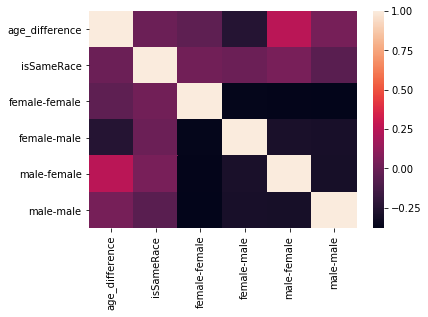

,age_difference,isSameRace,female-female,female-male,male-female,male-male
age_difference,1,0.000945176,-0.0441747,-0.24321,0.254003,0.0362518
isSameRace,0.000945176,1,0.0222601,-0.00311116,0.0411064,-0.0622542
female-female,-0.0441747,0.0222601,1,-0.367069,-0.372846,-0.381233
female-male,-0.24321,-0.00311116,-0.367069,1,-0.284661,-0.291065
male-female,0.254003,0.0411064,-0.372846,-0.284661,1,-0.295646
male-male,0.0362518,-0.0622542,-0.381233,-0.291065,-0.295646,1


             cols       vif
0  age_difference  1.109392
1      isSameRace  1.004682
2   female-female  6.473334
3     female-male  4.007219
4     male-female  5.849299
5       male-male  5.059257
dropping 'female-female' at index: 2
             cols       vif
0  age_difference  4.364018
1      isSameRace  2.847288
2     female-male  1.467204
3     male-female  1.754515
4       male-male  1.633840
Remaining variables:
Index(['age_difference', 'isSameRace', 'female-male', 'male-female',
       'male-male'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     9718.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:24:11   Log-Likelihood:                

In [1118]:
analysis.test_features(shared_demo_X, shared_demo_Y, vif_thresh=5)

### Relative Satisfaction

In [1119]:
shared_demo = shared_set[["relative_satisfaction"]+demo_feats]

In [1120]:
shared_demo['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [1121]:
shared_demo = analysis.get_dummies(shared_demo, 'gender_pairing')

In [1122]:
shared_demo_X,shared_demo_Y = get_x_y(shared_demo, 'relative_satisfaction')

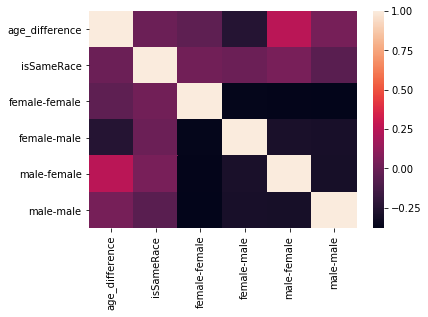

,age_difference,isSameRace,female-female,female-male,male-female,male-male
age_difference,1,0.000945176,-0.0441747,-0.24321,0.254003,0.0362518
isSameRace,0.000945176,1,0.0222601,-0.00311116,0.0411064,-0.0622542
female-female,-0.0441747,0.0222601,1,-0.367069,-0.372846,-0.381233
female-male,-0.24321,-0.00311116,-0.367069,1,-0.284661,-0.291065
male-female,0.254003,0.0411064,-0.372846,-0.284661,1,-0.295646
male-male,0.0362518,-0.0622542,-0.381233,-0.291065,-0.295646,1


             cols       vif
0  age_difference  1.109392
1      isSameRace  1.004682
2   female-female  6.473334
3     female-male  4.007219
4     male-female  5.849299
5       male-male  5.059257
dropping 'female-female' at index: 2
             cols       vif
0  age_difference  4.364018
1      isSameRace  2.847288
2     female-male  1.467204
3     male-female  1.754515
4       male-male  1.633840
Remaining variables:
Index(['age_difference', 'isSameRace', 'female-male', 'male-female',
       'male-male'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.921
Model:                               OLS   Adj. R-squared:                  0.921
Method:                    Least Squares   F-statistic:                     9464.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:24:20   Log-Likelihoo

In [1123]:
analysis.test_features(shared_demo_X, shared_demo_Y, vif_thresh=5)

# EXTRA

# Profile

# Full

### Satisfaction

In [929]:
full_profile= full_set[["relative_satisfaction"]+profiles_feat]

In [930]:
full_profile_X,full_profile_Y = get_x_y(full_profile, 'relative_satisfaction')

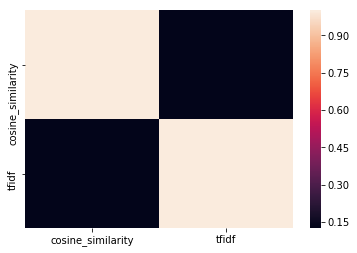

,cosine_similarity,tfidf
cosine_similarity,1,0.127243
tfidf,0.127243,1


                cols       vif
0  cosine_similarity  1.080676
1              tfidf  1.080676
Remaining variables:
Index(['cosine_similarity', 'tfidf'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.276
Model:                               OLS   Adj. R-squared:                  0.276
Method:                    Least Squares   F-statistic:                     1850.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:09:05   Log-Likelihood:                -9012.3
No. Observations:                   9716   AIC:                         1.803e+04
Df Residuals:                       9714   BIC:                         1.804e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
            

In [931]:
analysis.test_features(full_profile_X, full_profile_Y, vif_thresh=10)

### Relative Satisfaction

In [949]:
full_profile = full_set[["relative_satisfaction"]+profiles_feat]

In [950]:
full_profile_X,full_profile_Y = get_x_y(full_profile, 'relative_satisfaction')

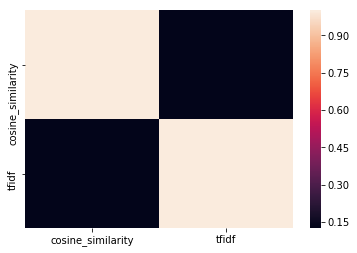

,cosine_similarity,tfidf
cosine_similarity,1,0.127243
tfidf,0.127243,1


                cols       vif
0  cosine_similarity  1.080676
1              tfidf  1.080676
Remaining variables:
Index(['cosine_similarity', 'tfidf'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.276
Model:                               OLS   Adj. R-squared:                  0.276
Method:                    Least Squares   F-statistic:                     1850.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:11:10   Log-Likelihood:                -9012.3
No. Observations:                   9716   AIC:                         1.803e+04
Df Residuals:                       9714   BIC:                         1.804e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
            

In [951]:
analysis.test_features(full_profile_X, full_profile_Y, vif_thresh=10)

# Shared

### Satisfaction

In [940]:
shared_profile = shared_set[["satisfaction"]+profiles_feat]

In [941]:
shared_profile_X,shared_profile_Y = get_x_y(shared_profile, 'satisfaction')

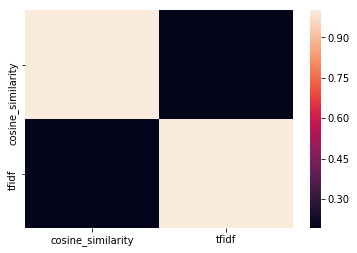

,cosine_similarity,tfidf
cosine_similarity,1,0.192888
tfidf,0.192888,1


                cols       vif
0  cosine_similarity  1.136614
1              tfidf  1.136614
Remaining variables:
Index(['cosine_similarity', 'tfidf'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     1177.
Date:                Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:09:55   Log-Likelihood:                -5512.5
No. Observations:                5883   AIC:                         1.103e+04
Df Residuals:                    5881   BIC:                         1.104e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err   

In [942]:
analysis.test_features(shared_profile_X, shared_profile_Y, vif_thresh=10)

### Relative Satisfaction

In [946]:
shared_profile = shared_set[["relative_satisfaction"]+profiles_feat]

In [947]:
shared_profile_X,shared_profile_Y = get_x_y(shared_profile, 'relative_satisfaction')

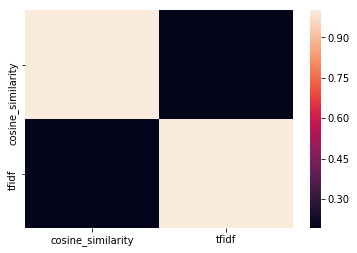

,cosine_similarity,tfidf
cosine_similarity,1,0.192888
tfidf,0.192888,1


                cols       vif
0  cosine_similarity  1.136614
1              tfidf  1.136614
Remaining variables:
Index(['cosine_similarity', 'tfidf'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.284
Model:                               OLS   Adj. R-squared:                  0.284
Method:                    Least Squares   F-statistic:                     1166.
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):               0.00
Time:                           17:10:22   Log-Likelihood:                -5088.9
No. Observations:                   5883   AIC:                         1.018e+04
Df Residuals:                       5881   BIC:                         1.020e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
            

In [948]:
analysis.test_features(shared_profile_X, shared_profile_Y, vif_thresh=10)

# Demographics + Race - pairing

# Full

### Satisfaction

In [764]:
full_demo = full_set[["satisfaction"]+demo_feats]

In [765]:
full_demo['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [766]:
full_demo = analysis.get_dummies(full_demo, 'gender_pairing')

In [767]:
full_demo['race_pairing'].value_counts()

White-White          3853
White-African         665
African-White         555
African-African       108
White-Hispanic         63
White-Asian            48
Hispanic-White         41
Asian-White            32
African-Hispanic       10
African-Asian           9
Asian-African           8
Hispanic-African        5
Hispanic-Hispanic       1
Name: race_pairing, dtype: int64

In [768]:
full_demo = analysis.get_dummies(full_demo, 'race_pairing')

full_demo['age-pairing'].value_counts()

full_demo = analysis.get_dummies(full_demo, 'age-pairing')

In [769]:
full_demo_X,full_demo_Y = get_x_y(full_demo, 'satisfaction')

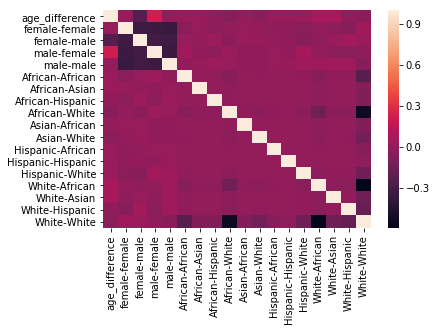

,age_difference,female-female,female-male,male-female,male-male,African-African,African-Asian,African-Hispanic,African-White,Asian-African,Asian-White,Hispanic-African,Hispanic-Hispanic,Hispanic-White,White-African,White-Asian,White-Hispanic,White-White
age_difference,1,0.0107637,-0.23713,0.217227,0.00364138,0.0203048,0.0235621,-0.00839609,-0.0517619,-0.00208833,-0.0405274,0.0177165,0.00640971,0.0112608,0.0678542,0.0697836,-0.0167763,-0.0291711
female-female,0.0107637,1,-0.328659,-0.342725,-0.355237,-0.0289201,0.00629912,-0.025887,-0.00446575,0.00957432,0.00279284,-0.0182964,-0.00817935,-0.0429022,-0.00180467,-0.025628,-0.0535766,0.0416494
female-male,-0.23713,-0.328659,1,-0.311961,-0.323351,0.00983843,-0.000781233,0.0276011,-0.031584,0.013244,0.0208151,-0.00218928,-0.00744516,-0.0478499,-0.0256121,0.00912608,0.0593788,0.0231387
male-female,0.217227,-0.342725,-0.311961,1,-0.33719,0.0322486,-0.0127577,-0.0245718,0.029436,-0.0107837,-0.0104005,0.0109339,-0.0077638,0.0492641,-0.00685229,-0.0219277,-0.0419402,-0.0140591
male-male,0.00364138,-0.355237,-0.323351,-0.33719,1,-0.0119906,0.00693568,0.0237017,0.00593615,-0.011783,-0.0126012,0.00980133,0.023025,0.0408249,0.0331643,0.0385983,0.0381298,-0.0503988
African-African,0.0203048,-0.0289201,0.00983843,0.0322486,-0.0119906,1,-0.00583917,-0.0061556,-0.0483697,-0.00550471,-0.011034,-0.00435065,-0.00194495,-0.0125001,-0.0535583,-0.013534,-0.015527,-0.225642
African-Asian,0.0235621,0.00629912,-0.000781233,-0.0127577,0.00693568,-0.00583917,1,-0.00176057,-0.0138343,-0.00157441,-0.00315585,-0.00124433,-0.000556277,-0.00357518,-0.0153183,-0.00387089,-0.00444089,-0.0645361
African-Hispanic,-0.00839609,-0.025887,0.0276011,-0.0245718,0.0237017,-0.0061556,-0.00176057,1,-0.014584,-0.00165973,-0.00332687,-0.00131176,-0.000586422,-0.00376892,-0.0161484,-0.00408066,-0.00468155,-0.0680333
African-White,-0.0517619,-0.00446575,-0.031584,0.029436,0.00593615,-0.0483697,-0.0138343,-0.014584,1,-0.0130419,-0.026142,-0.0103076,-0.00460801,-0.0296156,-0.126891,-0.0320651,-0.0367868,-0.534595
Asian-African,-0.00208833,0.00957432,0.013244,-0.0107837,-0.011783,-0.00550471,-0.00157441,-0.00165973,-0.0130419,1,-0.00297509,-0.00117306,-0.000524414,-0.0033704,-0.0144409,-0.00364917,-0.00418652,-0.0608395


/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                 cols       vif
0      age_difference  1.102833
1       female-female       inf
2         female-male       inf
3         male-female       inf
4           male-male       inf
5     African-African       inf
6       African-Asian       inf
7    African-Hispanic       inf
8       African-White       inf
9       Asian-African       inf
10        Asian-White       inf
11   Hispanic-African       inf
12  Hispanic-Hispanic       inf
13     Hispanic-White       inf
14      White-African       inf
15        White-Asian       inf
16     White-Hispanic       inf
17        White-White       inf
dropping 'female-female' at index: 1
                 cols        vif
0      age_difference   1.104160
1         female-male   1.489766
2         male-female   1.488544
3           male-male   1.479936
4     African-African   1.458467
5       African-Asian   1.044531
6    African-Hispanic   1.045157
7       African-White   3.006287
8       Asian-African   1.031095
9         Asian-White   1

In [770]:
analysis.test_features(full_demo_X, full_demo_Y, vif_thresh=5)

### Relative Satisfaction

In [860]:
full_demo = full_set[["relative_satisfaction"]+demo_feats]

In [861]:
full_demo['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [862]:
full_demo = analysis.get_dummies(full_demo, 'gender_pairing')

In [863]:
full_demo_X,full_demo_Y = get_x_y(full_demo, 'relative_satisfaction')

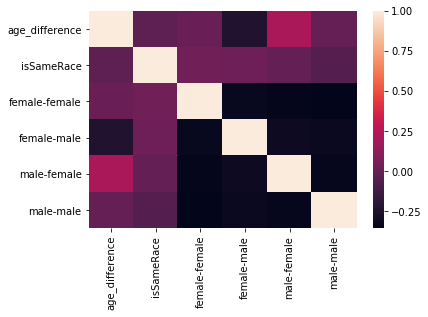

,age_difference,isSameRace,female-female,female-male,male-female,male-male
age_difference,1,-0.0232071,0.0107637,-0.23713,0.217227,0.00364138
isSameRace,-0.0232071,1,0.0331864,0.0265567,-0.00440089,-0.054643
female-female,0.0107637,0.0331864,1,-0.328659,-0.342725,-0.355237
female-male,-0.23713,0.0265567,-0.328659,1,-0.311961,-0.323351
male-female,0.217227,-0.00440089,-0.342725,-0.311961,1,-0.33719
male-male,0.00364138,-0.054643,-0.355237,-0.323351,-0.33719,1


             cols       vif
0  age_difference  1.086128
1      isSameRace  1.003937
2   female-female  6.616777
3     female-male  4.996101
4     male-female  6.969846
5       male-male  6.324266
Remaining variables:
Index(['age_difference', 'isSameRace', 'female-female', 'female-male',
       'male-female', 'male-male'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.005
Model:                               OLS   Adj. R-squared:                  0.004
Method:                    Least Squares   F-statistic:                     4.898
Date:                   Sun, 09 Sep 2018   Prob (F-statistic):           0.000179
Time:                           17:00:33   Log-Likelihood:                 3544.2
No. Observations:                   5398   AIC:                            -7076.
Df Residuals:                       5392   BIC:                            -7037

In [864]:
analysis.test_features(full_demo_X, full_demo_Y, vif_thresh=10)

# Shared

### Satisfaction

In [771]:
shared_demo = shared_set[["satisfaction"]+demo_feats]

In [772]:
shared_demo['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [773]:
shared_demo = analysis.get_dummies(shared_demo, 'gender_pairing')

In [774]:
shared_demo['race_pairing'].value_counts()

White-White         2688
African-White        526
White-African        490
African-African      127
Asian-White           75
White-Asian           58
White-Hispanic        41
Hispanic-White        30
Asian-African         18
Hispanic-African      11
African-Hispanic       9
African-Asian          9
Asian-Hispanic         1
Asian-Asian            1
Name: race_pairing, dtype: int64

In [775]:
shared_demo = analysis.get_dummies(shared_demo, 'race_pairing')

In [776]:
shared_demo_X,shared_demo_Y = get_x_y(shared_demo, 'satisfaction')

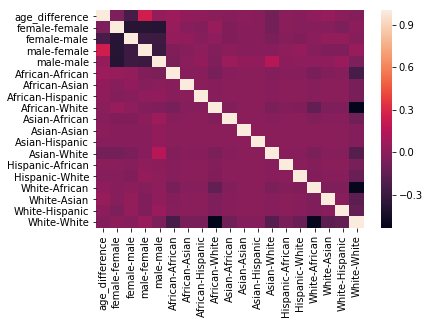

,age_difference,female-female,female-male,male-female,male-male,African-African,African-Asian,African-Hispanic,African-White,Asian-African,Asian-Asian,Asian-Hispanic,Asian-White,Hispanic-African,Hispanic-White,White-African,White-Asian,White-Hispanic,White-White
age_difference,1,-0.0441747,-0.24321,0.254003,0.0362518,0.0605138,0.0269022,0.018442,-0.00495819,-0.0120016,0.00127502,-0.0102504,-0.0784391,-0.0055081,-0.014109,0.0200934,0.0437647,0.00368227,-0.0212654
female-female,-0.0441747,1,-0.367069,-0.372846,-0.381233,0.0444813,-0.0102832,-0.0214346,0.0471714,-0.0303467,-0.0108514,-0.0108514,-0.0831551,-0.00576605,-0.0167817,-0.0114162,-0.0125138,-0.0435989,0.00579408
female-male,-0.24321,-0.367069,1,-0.284661,-0.291065,0.0347943,0.0256334,-0.0122508,0.0156571,-0.035223,-0.00828483,-0.00828483,-0.0591769,-0.0160861,-0.0316708,0.00863346,0.0315472,0.0298478,-0.0154947
male-female,0.254003,-0.372846,-0.284661,1,-0.295646,-0.0354586,-0.0127517,0.0122858,-0.0297507,0.00853205,-0.00841522,-0.00841522,-0.00796497,0.0173612,0.0362377,-0.0124692,-0.039734,-0.0364842,0.0533523
male-male,0.0362518,-0.381233,-0.291065,-0.295646,1,-0.048381,-0.00110236,0.0236342,-0.0382604,0.0597268,0.0284639,0.0284639,0.158057,0.0049978,0.0138299,0.0165253,0.0222375,0.0551682,-0.0439614
African-African,0.0605138,0.0444813,0.0347943,-0.0354586,-0.048381,1,-0.00841931,-0.00841931,-0.0688825,-0.0119199,-0.00280368,-0.00280368,-0.0245037,-0.00931018,-0.0154112,-0.0661497,-0.0215028,-0.0180409,-0.248594
African-Asian,0.0269022,-0.0102832,0.0256334,-0.0127517,-0.00110236,-0.00841931,1,-0.00220859,-0.0180696,-0.00312687,-0.000735475,-0.000735475,-0.00642791,-0.00244229,-0.00404274,-0.0173527,-0.00564072,-0.00473258,-0.0652123
African-Hispanic,0.018442,-0.0214346,-0.0122508,0.0122858,0.0236342,-0.00841931,-0.00220859,1,-0.0180696,-0.00312687,-0.000735475,-0.000735475,-0.00642791,-0.00244229,-0.00404274,-0.0173527,-0.00564072,-0.00473258,-0.0652123
African-White,-0.00495819,0.0471714,0.0156571,-0.0297507,-0.0382604,-0.0688825,-0.0180696,-0.0180696,1,-0.0255825,-0.00601728,-0.00601728,-0.0525899,-0.0199815,-0.0330757,-0.141971,-0.0461495,-0.0387195,-0.533534
Asian-African,-0.0120016,-0.0303467,-0.035223,0.00853205,0.0597268,-0.0119199,-0.00312687,-0.00312687,-0.0255825,1,-0.00104127,-0.00104127,-0.0091005,-0.00345773,-0.00572363,-0.0245675,-0.00798601,-0.00670027,-0.0923261


/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                cols       vif
0     age_difference  1.136895
1      female-female       inf
2        female-male       inf
3        male-female       inf
4          male-male       inf
5    African-African       inf
6      African-Asian       inf
7   African-Hispanic       inf
8      African-White       inf
9      Asian-African       inf
10       Asian-Asian       inf
11    Asian-Hispanic       inf
12       Asian-White       inf
13  Hispanic-African       inf
14    Hispanic-White       inf
15     White-African       inf
16       White-Asian       inf
17    White-Hispanic       inf
18       White-White       inf
dropping 'female-female' at index: 1
                cols        vif
0     age_difference   1.137391
1        female-male   1.344784
2        male-female   1.386104
3          male-male   1.374814
4    African-African   1.622806
5      African-Asian   1.053631
6   African-Hispanic   1.045696
7      African-White   3.142313
8      Asian-African   1.072188
9        Asian-Asian   

In [777]:
analysis.test_features(shared_demo_X, shared_demo_Y, vif_thresh=10)

### Relative Satisfaction

In [778]:
shared_demo = shared_set[["relative_satisfaction"]+demo_feats]

In [779]:
shared_demo['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [780]:
shared_demo = analysis.get_dummies(shared_demo, 'gender_pairing')

In [781]:
shared_demo['race_pairing'].value_counts()

White-White         2688
African-White        526
White-African        490
African-African      127
Asian-White           75
White-Asian           58
White-Hispanic        41
Hispanic-White        30
Asian-African         18
Hispanic-African      11
African-Hispanic       9
African-Asian          9
Asian-Hispanic         1
Asian-Asian            1
Name: race_pairing, dtype: int64

In [782]:
shared_demo = analysis.get_dummies(shared_demo, 'race_pairing')

In [783]:
shared_demo_X,shared_demo_Y = get_x_y(shared_demo, 'relative_satisfaction')

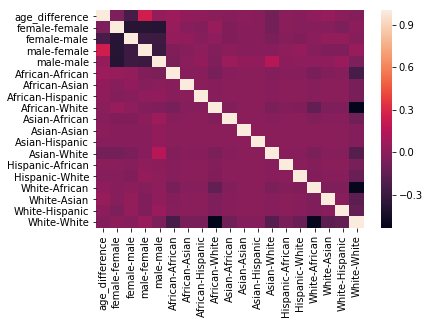

,age_difference,female-female,female-male,male-female,male-male,African-African,African-Asian,African-Hispanic,African-White,Asian-African,Asian-Asian,Asian-Hispanic,Asian-White,Hispanic-African,Hispanic-White,White-African,White-Asian,White-Hispanic,White-White
age_difference,1,-0.0441747,-0.24321,0.254003,0.0362518,0.0605138,0.0269022,0.018442,-0.00495819,-0.0120016,0.00127502,-0.0102504,-0.0784391,-0.0055081,-0.014109,0.0200934,0.0437647,0.00368227,-0.0212654
female-female,-0.0441747,1,-0.367069,-0.372846,-0.381233,0.0444813,-0.0102832,-0.0214346,0.0471714,-0.0303467,-0.0108514,-0.0108514,-0.0831551,-0.00576605,-0.0167817,-0.0114162,-0.0125138,-0.0435989,0.00579408
female-male,-0.24321,-0.367069,1,-0.284661,-0.291065,0.0347943,0.0256334,-0.0122508,0.0156571,-0.035223,-0.00828483,-0.00828483,-0.0591769,-0.0160861,-0.0316708,0.00863346,0.0315472,0.0298478,-0.0154947
male-female,0.254003,-0.372846,-0.284661,1,-0.295646,-0.0354586,-0.0127517,0.0122858,-0.0297507,0.00853205,-0.00841522,-0.00841522,-0.00796497,0.0173612,0.0362377,-0.0124692,-0.039734,-0.0364842,0.0533523
male-male,0.0362518,-0.381233,-0.291065,-0.295646,1,-0.048381,-0.00110236,0.0236342,-0.0382604,0.0597268,0.0284639,0.0284639,0.158057,0.0049978,0.0138299,0.0165253,0.0222375,0.0551682,-0.0439614
African-African,0.0605138,0.0444813,0.0347943,-0.0354586,-0.048381,1,-0.00841931,-0.00841931,-0.0688825,-0.0119199,-0.00280368,-0.00280368,-0.0245037,-0.00931018,-0.0154112,-0.0661497,-0.0215028,-0.0180409,-0.248594
African-Asian,0.0269022,-0.0102832,0.0256334,-0.0127517,-0.00110236,-0.00841931,1,-0.00220859,-0.0180696,-0.00312687,-0.000735475,-0.000735475,-0.00642791,-0.00244229,-0.00404274,-0.0173527,-0.00564072,-0.00473258,-0.0652123
African-Hispanic,0.018442,-0.0214346,-0.0122508,0.0122858,0.0236342,-0.00841931,-0.00220859,1,-0.0180696,-0.00312687,-0.000735475,-0.000735475,-0.00642791,-0.00244229,-0.00404274,-0.0173527,-0.00564072,-0.00473258,-0.0652123
African-White,-0.00495819,0.0471714,0.0156571,-0.0297507,-0.0382604,-0.0688825,-0.0180696,-0.0180696,1,-0.0255825,-0.00601728,-0.00601728,-0.0525899,-0.0199815,-0.0330757,-0.141971,-0.0461495,-0.0387195,-0.533534
Asian-African,-0.0120016,-0.0303467,-0.035223,0.00853205,0.0597268,-0.0119199,-0.00312687,-0.00312687,-0.0255825,1,-0.00104127,-0.00104127,-0.0091005,-0.00345773,-0.00572363,-0.0245675,-0.00798601,-0.00670027,-0.0923261


/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                cols       vif
0     age_difference  1.136895
1      female-female       inf
2        female-male       inf
3        male-female       inf
4          male-male       inf
5    African-African       inf
6      African-Asian       inf
7   African-Hispanic       inf
8      African-White       inf
9      Asian-African       inf
10       Asian-Asian       inf
11    Asian-Hispanic       inf
12       Asian-White       inf
13  Hispanic-African       inf
14    Hispanic-White       inf
15     White-African       inf
16       White-Asian       inf
17    White-Hispanic       inf
18       White-White       inf
dropping 'female-female' at index: 1
                cols        vif
0     age_difference   1.137391
1        female-male   1.344784
2        male-female   1.386104
3          male-male   1.374814
4    African-African   1.622806
5      African-Asian   1.053631
6   African-Hispanic   1.045696
7      African-White   3.142313
8      Asian-African   1.072188
9        Asian-Asian   

In [784]:
analysis.test_features(shared_demo_X, shared_demo_Y, vif_thresh=10)

# Profile Emotion + emotion pairing

# Full

### Satisfaction

In [829]:
full_emotion = full_set[["satisfaction"]+demo_emotion]

In [830]:
full_emotion['emotion_pairing'].value_counts()

happiness-happiness    1733
sadness-happiness       709
happiness-sadness       440
happiness-anger         318
anger-happiness         305
disgust-happiness       223
happiness-disgust       205
sadness-sadness         181
happiness-fear          175
fear-happiness          133
sadness-anger           129
anger-sadness            96
sadness-disgust          91
sadness-fear             82
anger-anger              64
disgust-sadness          62
happiness-surprise       56
surprise-happiness       48
disgust-anger            48
anger-disgust            42
fear-sadness             40
disgust-fear             35
anger-fear               30
sadness-surprise         28
fear-anger               24
disgust-disgust          23
fear-disgust             13
fear-fear                13
surprise-sadness         12
anger-surprise           11
disgust-surprise          9
surprise-anger            7
surprise-disgust          6
fear-surprise             4
surprise-surprise         2
surprise-fear       

In [831]:
full_emotion = analysis.get_dummies(full_emotion, 'emotion_pairing')

In [832]:
full_emotion_X,full_emotion_Y = get_x_y(full_emotion, 'satisfaction')

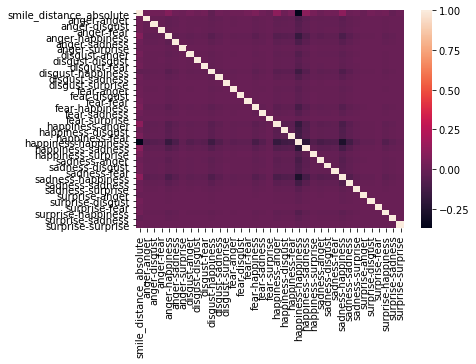

,smile_distance_absolute,anger-anger,anger-disgust,anger-fear,anger-happiness,anger-sadness,anger-surprise,disgust-anger,disgust-disgust,disgust-fear,disgust-happiness,disgust-sadness,disgust-surprise,fear-anger,fear-disgust,fear-fear,fear-happiness,fear-sadness,fear-surprise,happiness-anger,happiness-disgust,happiness-fear,happiness-happiness,happiness-sadness,happiness-surprise,sadness-anger,sadness-disgust,sadness-fear,sadness-happiness,sadness-sadness,sadness-surprise,surprise-anger,surprise-disgust,surprise-fear,surprise-happiness,surprise-sadness,surprise-surprise
smile_distance_absolute,1,0.0244582,0.0245334,0.0261454,0.0849225,0.0198541,0.00785315,0.0358031,0.0142226,0.029443,-0.0297415,0.019255,0.00956766,0.015384,0.0117704,0.0354288,0.0591227,0.0209854,-0.00284114,0.11526,0.0141084,0.0524182,-0.369251,0.105505,0.0474756,0.00780008,0.0299232,0.024975,0.113347,0.00953266,0.0173117,-0.0037316,0.0326279,0.0199308,0.0311513,-0.0157046,0.0058685
anger-anger,0.0244582,1,-0.00969991,-0.00818875,-0.0268057,-0.0147394,-0.00494979,-0.0103755,-0.00716536,-0.00884899,-0.0227384,-0.0118073,-0.00447642,-0.00732015,-0.00538198,-0.00538198,-0.0174097,-0.00946438,-0.0029829,-0.027406,-0.0217636,-0.0200504,-0.0753227,-0.0326315,-0.0112152,-0.0171393,-0.0143436,-0.0136044,-0.0425938,-0.0204029,-0.00790962,-0.0039471,-0.00365396,-0.00149103,-0.0103755,-0.00517036,-0.00210883
anger-disgust,0.0245334,-0.00969991,1,-0.00662001,-0.0216704,-0.0119157,-0.00400154,-0.0083878,-0.00579267,-0.00715376,-0.0183824,-0.00954536,-0.00361886,-0.00591781,-0.00435094,-0.00435094,-0.0140744,-0.00765126,-0.00241145,-0.0221557,-0.0175943,-0.0162093,-0.0608929,-0.0263802,-0.00906664,-0.0138559,-0.0115958,-0.0109981,-0.034434,-0.0164943,-0.00639435,-0.00319094,-0.00295396,-0.00120539,-0.0083878,-0.00417986,-0.00170484
anger-fear,0.0261454,-0.00818875,-0.00662001,1,-0.0182944,-0.0100594,-0.00337814,-0.00708106,-0.00489023,-0.00603927,-0.0155186,-0.00805828,-0.00305507,-0.00499587,-0.0036731,-0.0036731,-0.0118818,-0.00645926,-0.00203577,-0.0187041,-0.0148533,-0.013684,-0.0514063,-0.0222704,-0.00765414,-0.0116973,-0.00978927,-0.00928472,-0.0290695,-0.0139246,-0.00539817,-0.00269382,-0.00249376,-0.0010176,-0.00708106,-0.00352868,-0.00143924
anger-happiness,0.0849225,-0.0268057,-0.0216704,-0.0182944,1,-0.032929,-0.0110582,-0.0231796,-0.016008,-0.0197694,-0.0507996,-0.0263786,-0.0100007,-0.0163538,-0.0120238,-0.0120238,-0.0388946,-0.0211442,-0.00666404,-0.0612273,-0.0486218,-0.0447942,-0.168277,-0.0729014,-0.0250556,-0.0382907,-0.0320449,-0.0303933,-0.0951582,-0.0455819,-0.0176707,-0.00881815,-0.00816326,-0.00333109,-0.0231796,-0.011551,-0.00471131
anger-sadness,0.0198541,-0.0147394,-0.0119157,-0.0100594,-0.032929,1,-0.00608049,-0.0127456,-0.00880218,-0.0108704,-0.0279327,-0.0145045,-0.00549899,-0.00899234,-0.00661142,-0.00661142,-0.0213866,-0.0116264,-0.00366429,-0.0336665,-0.0267352,-0.0246306,-0.092529,-0.0400856,-0.0137771,-0.0210546,-0.0176202,-0.0167121,-0.0523237,-0.0250637,-0.00971645,-0.00484875,-0.00448866,-0.00183164,-0.0127456,-0.00635145,-0.00259057
anger-surprise,0.00785315,-0.00494979,-0.00400154,-0.00337814,-0.0110582,-0.00608049,1,-0.00428022,-0.00295595,-0.00365051,-0.00938037,-0.00487092,-0.00184667,-0.00301981,-0.00222025,-0.00222025,-0.00718207,-0.00390437,-0.00123054,-0.0113059,-0.00897823,-0.00827145,-0.0310731,-0.0134616,-0.00462663,-0.00707056,-0.00591724,-0.00561225,-0.0175714,-0.00841689,-0.00326298,-0.00162831,-0.00150738,-0.000615101,-0.00428022,-0.00213295,-0.000869965
disgust-anger,0.0358031,-0.0103755,-0.0083878,-0.00708106,-0.0231796,-0.0127456,-0.00428022,1,-0.0061961,-0.00765198,-0.0196626,-0.0102101,-0.00387089,-0.00632995,-0.00465396,-0.00465396,-0.0150546,-0.00818413,-0.0025794,-0.0236987,-0.0188196,-0.0173381,-0.0651337,-0.0282174,-0.00969808,-0.0148209,-0.0124034,-0.0117641,-0.0368321,-0.017643,-0.00683968,-0.00341317,-0.00315969,-0.00128934,-0.00897196,-0.00447096,-0.00182357
disgust-disgust,0.0142226,-0.00716536,-0.00579267,

                       cols       vif
0   smile_distance_absolute  1.182644
1               anger-anger  1.019176
2             anger-disgust  1.013768
3                anger-fear  1.011038
4           anger-happiness  1.111746
5             anger-sadness  1.025158
6            anger-surprise  1.003023
7             disgust-anger  1.018438
8           disgust-disgust  1.006822
9              disgust-fear  1.013171
10        disgust-happiness  1.031493
11          disgust-sadness  1.017185
12         disgust-surprise  1.002747
13               fear-anger  1.007276
14             fear-disgust  1.004004
15                fear-fear  1.007917
16           fear-happiness  1.050628
17             fear-sadness  1.012390
18            fear-surprise  1.000621
19          happiness-anger  1.137888
20        happiness-disgust  1.046467
21           happiness-fear  1.058243
22      happiness-happiness  1.063564
23        happiness-sadness  1.162991
24       happiness-surprise  1.024386
25          

In [833]:
analysis.test_features(full_emotion_X, full_emotion_Y, vif_thresh=10)

### Relative Satisfaction

In [834]:
full_emotion = full_set[["relative_satisfaction"]+demo_emotion]

In [835]:
full_emotion['emotion_pairing'].value_counts()

happiness-happiness    1733
sadness-happiness       709
happiness-sadness       440
happiness-anger         318
anger-happiness         305
disgust-happiness       223
happiness-disgust       205
sadness-sadness         181
happiness-fear          175
fear-happiness          133
sadness-anger           129
anger-sadness            96
sadness-disgust          91
sadness-fear             82
anger-anger              64
disgust-sadness          62
happiness-surprise       56
surprise-happiness       48
disgust-anger            48
anger-disgust            42
fear-sadness             40
disgust-fear             35
anger-fear               30
sadness-surprise         28
fear-anger               24
disgust-disgust          23
fear-disgust             13
fear-fear                13
surprise-sadness         12
anger-surprise           11
disgust-surprise          9
surprise-anger            7
surprise-disgust          6
fear-surprise             4
surprise-surprise         2
surprise-fear       

In [836]:
full_emotion = analysis.get_dummies(full_emotion, 'emotion_pairing')

In [837]:
full_emotion_X,full_emotion_Y = get_x_y(full_emotion, 'relative_satisfaction')

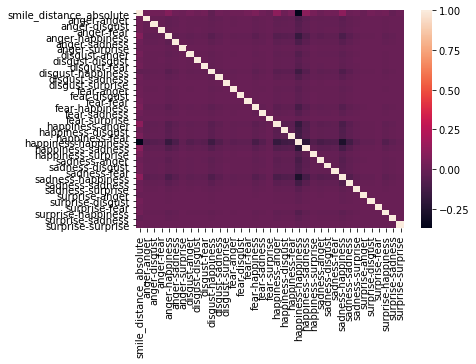

,smile_distance_absolute,anger-anger,anger-disgust,anger-fear,anger-happiness,anger-sadness,anger-surprise,disgust-anger,disgust-disgust,disgust-fear,disgust-happiness,disgust-sadness,disgust-surprise,fear-anger,fear-disgust,fear-fear,fear-happiness,fear-sadness,fear-surprise,happiness-anger,happiness-disgust,happiness-fear,happiness-happiness,happiness-sadness,happiness-surprise,sadness-anger,sadness-disgust,sadness-fear,sadness-happiness,sadness-sadness,sadness-surprise,surprise-anger,surprise-disgust,surprise-fear,surprise-happiness,surprise-sadness,surprise-surprise
smile_distance_absolute,1,0.0244582,0.0245334,0.0261454,0.0849225,0.0198541,0.00785315,0.0358031,0.0142226,0.029443,-0.0297415,0.019255,0.00956766,0.015384,0.0117704,0.0354288,0.0591227,0.0209854,-0.00284114,0.11526,0.0141084,0.0524182,-0.369251,0.105505,0.0474756,0.00780008,0.0299232,0.024975,0.113347,0.00953266,0.0173117,-0.0037316,0.0326279,0.0199308,0.0311513,-0.0157046,0.0058685
anger-anger,0.0244582,1,-0.00969991,-0.00818875,-0.0268057,-0.0147394,-0.00494979,-0.0103755,-0.00716536,-0.00884899,-0.0227384,-0.0118073,-0.00447642,-0.00732015,-0.00538198,-0.00538198,-0.0174097,-0.00946438,-0.0029829,-0.027406,-0.0217636,-0.0200504,-0.0753227,-0.0326315,-0.0112152,-0.0171393,-0.0143436,-0.0136044,-0.0425938,-0.0204029,-0.00790962,-0.0039471,-0.00365396,-0.00149103,-0.0103755,-0.00517036,-0.00210883
anger-disgust,0.0245334,-0.00969991,1,-0.00662001,-0.0216704,-0.0119157,-0.00400154,-0.0083878,-0.00579267,-0.00715376,-0.0183824,-0.00954536,-0.00361886,-0.00591781,-0.00435094,-0.00435094,-0.0140744,-0.00765126,-0.00241145,-0.0221557,-0.0175943,-0.0162093,-0.0608929,-0.0263802,-0.00906664,-0.0138559,-0.0115958,-0.0109981,-0.034434,-0.0164943,-0.00639435,-0.00319094,-0.00295396,-0.00120539,-0.0083878,-0.00417986,-0.00170484
anger-fear,0.0261454,-0.00818875,-0.00662001,1,-0.0182944,-0.0100594,-0.00337814,-0.00708106,-0.00489023,-0.00603927,-0.0155186,-0.00805828,-0.00305507,-0.00499587,-0.0036731,-0.0036731,-0.0118818,-0.00645926,-0.00203577,-0.0187041,-0.0148533,-0.013684,-0.0514063,-0.0222704,-0.00765414,-0.0116973,-0.00978927,-0.00928472,-0.0290695,-0.0139246,-0.00539817,-0.00269382,-0.00249376,-0.0010176,-0.00708106,-0.00352868,-0.00143924
anger-happiness,0.0849225,-0.0268057,-0.0216704,-0.0182944,1,-0.032929,-0.0110582,-0.0231796,-0.016008,-0.0197694,-0.0507996,-0.0263786,-0.0100007,-0.0163538,-0.0120238,-0.0120238,-0.0388946,-0.0211442,-0.00666404,-0.0612273,-0.0486218,-0.0447942,-0.168277,-0.0729014,-0.0250556,-0.0382907,-0.0320449,-0.0303933,-0.0951582,-0.0455819,-0.0176707,-0.00881815,-0.00816326,-0.00333109,-0.0231796,-0.011551,-0.00471131
anger-sadness,0.0198541,-0.0147394,-0.0119157,-0.0100594,-0.032929,1,-0.00608049,-0.0127456,-0.00880218,-0.0108704,-0.0279327,-0.0145045,-0.00549899,-0.00899234,-0.00661142,-0.00661142,-0.0213866,-0.0116264,-0.00366429,-0.0336665,-0.0267352,-0.0246306,-0.092529,-0.0400856,-0.0137771,-0.0210546,-0.0176202,-0.0167121,-0.0523237,-0.0250637,-0.00971645,-0.00484875,-0.00448866,-0.00183164,-0.0127456,-0.00635145,-0.00259057
anger-surprise,0.00785315,-0.00494979,-0.00400154,-0.00337814,-0.0110582,-0.00608049,1,-0.00428022,-0.00295595,-0.00365051,-0.00938037,-0.00487092,-0.00184667,-0.00301981,-0.00222025,-0.00222025,-0.00718207,-0.00390437,-0.00123054,-0.0113059,-0.00897823,-0.00827145,-0.0310731,-0.0134616,-0.00462663,-0.00707056,-0.00591724,-0.00561225,-0.0175714,-0.00841689,-0.00326298,-0.00162831,-0.00150738,-0.000615101,-0.00428022,-0.00213295,-0.000869965
disgust-anger,0.0358031,-0.0103755,-0.0083878,-0.00708106,-0.0231796,-0.0127456,-0.00428022,1,-0.0061961,-0.00765198,-0.0196626,-0.0102101,-0.00387089,-0.00632995,-0.00465396,-0.00465396,-0.0150546,-0.00818413,-0.0025794,-0.0236987,-0.0188196,-0.0173381,-0.0651337,-0.0282174,-0.00969808,-0.0148209,-0.0124034,-0.0117641,-0.0368321,-0.017643,-0.00683968,-0.00341317,-0.00315969,-0.00128934,-0.00897196,-0.00447096,-0.00182357
disgust-disgust,0.0142226,-0.00716536,-0.00579267,

                       cols       vif
0   smile_distance_absolute  1.182644
1               anger-anger  1.019176
2             anger-disgust  1.013768
3                anger-fear  1.011038
4           anger-happiness  1.111746
5             anger-sadness  1.025158
6            anger-surprise  1.003023
7             disgust-anger  1.018438
8           disgust-disgust  1.006822
9              disgust-fear  1.013171
10        disgust-happiness  1.031493
11          disgust-sadness  1.017185
12         disgust-surprise  1.002747
13               fear-anger  1.007276
14             fear-disgust  1.004004
15                fear-fear  1.007917
16           fear-happiness  1.050628
17             fear-sadness  1.012390
18            fear-surprise  1.000621
19          happiness-anger  1.137888
20        happiness-disgust  1.046467
21           happiness-fear  1.058243
22      happiness-happiness  1.063564
23        happiness-sadness  1.162991
24       happiness-surprise  1.024386
25          

In [838]:
analysis.test_features(full_emotion_X, full_emotion_Y, vif_thresh=10)

# Shared

### Satisfaction

In [842]:
shared_emotion = shared_set[["satisfaction"]+demo_emotion]

In [843]:
shared_emotion['emotion_pairing'].value_counts()

happiness-happiness    1412
happiness-sadness       426
sadness-happiness       322
anger-happiness         267
happiness-anger         207
happiness-disgust       194
happiness-fear          163
fear-happiness          160
disgust-happiness       127
sadness-sadness         102
fear-sadness             71
happiness-surprise       65
anger-sadness            56
sadness-anger            55
sadness-disgust          54
disgust-sadness          45
surprise-happiness       42
sadness-fear             31
anger-anger              29
anger-fear               28
fear-anger               27
disgust-anger            25
anger-disgust            22
sadness-surprise         18
fear-disgust             17
fear-fear                17
surprise-sadness         16
disgust-disgust          16
surprise-disgust         12
anger-surprise           12
surprise-anger           11
disgust-fear             11
fear-surprise             8
disgust-surprise          7
surprise-fear             5
surprise-surprise   

In [844]:
shared_emotion = analysis.get_dummies(shared_emotion, 'emotion_pairing')

In [845]:
shared_emotion_X,shared_emotion_Y = get_x_y(shared_emotion, 'satisfaction')

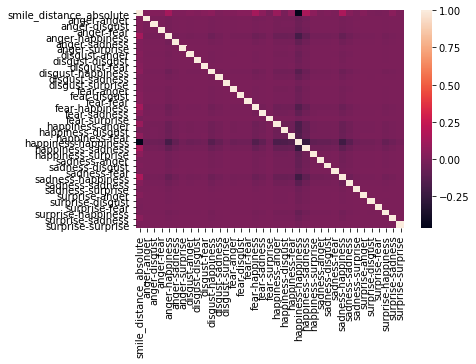

,smile_distance_absolute,anger-anger,anger-disgust,anger-fear,anger-happiness,anger-sadness,anger-surprise,disgust-anger,disgust-disgust,disgust-fear,disgust-happiness,disgust-sadness,disgust-surprise,fear-anger,fear-disgust,fear-fear,fear-happiness,fear-sadness,fear-surprise,happiness-anger,happiness-disgust,happiness-fear,happiness-happiness,happiness-sadness,happiness-surprise,sadness-anger,sadness-disgust,sadness-fear,sadness-happiness,sadness-sadness,sadness-surprise,surprise-anger,surprise-disgust,surprise-fear,surprise-happiness,surprise-sadness,surprise-surprise
smile_distance_absolute,1,0.0227925,0.0214585,0.0191114,0.13338,0.0102692,0.00883535,0.0239618,0.0127663,0.0294888,0.0505304,0.00248214,0.0149866,0.0167921,0.0339283,0.034236,0.136016,0.0471808,-0.0149226,0.0939518,-0.0148156,0.0585275,-0.462529,0.146116,0.0490183,-0.00411879,0.0110624,-0.00504202,0.159441,0.0239855,-8.39833e-05,0.0263181,-0.00916619,-0.0122513,-0.00817497,0.0406309,-0.00424985
anger-anger,0.0227925,1,-0.00622365,-0.00702641,-0.0223665,-0.00997132,-0.00459082,-0.00663688,-0.00530363,-0.00439484,-0.0151503,-0.00892633,-0.00350415,-0.00689895,-0.00546753,-0.00546753,-0.0170765,-0.0112486,-0.00374655,-0.0195407,-0.0188855,-0.0172424,-0.0614756,-0.0288593,-0.0107548,-0.00988067,-0.00978922,-0.00739599,-0.0247413,-0.0135348,-0.00562673,-0.00439484,-0.00459082,-0.00296082,-0.00862045,-0.00530363,-0.00264791
anger-disgust,0.0214585,-0.00622365,1,-0.00611465,-0.0194642,-0.00867742,-0.0039951,-0.00577566,-0.00461542,-0.00382455,-0.0131844,-0.00776803,-0.00304944,-0.00600372,-0.00475805,-0.00475805,-0.0148606,-0.00978895,-0.00326039,-0.0170051,-0.0164349,-0.015005,-0.0534984,-0.0251145,-0.00935921,-0.00859853,-0.00851894,-0.00643627,-0.0215308,-0.0117785,-0.00489659,-0.00382455,-0.0039951,-0.00257661,-0.00750184,-0.00461542,-0.00230431
anger-fear,0.0191114,-0.00702641,-0.00611465,1,-0.0219748,-0.00979669,-0.00451042,-0.00652064,-0.00521074,-0.00431787,-0.014885,-0.00877,-0.00344278,-0.00677812,-0.00537177,-0.00537177,-0.0167774,-0.0110516,-0.00368093,-0.0191985,-0.0185548,-0.0169405,-0.0603989,-0.0283539,-0.0105664,-0.00970762,-0.00961777,-0.00726645,-0.024308,-0.0132978,-0.00552819,-0.00431787,-0.00451042,-0.00290896,-0.00846948,-0.00521074,-0.00260154
anger-happiness,0.13338,-0.0223665,-0.0194642,-0.0219748,1,-0.0311849,-0.0143576,-0.0207565,-0.0165869,-0.0137447,-0.047382,-0.0279167,-0.0109591,-0.0215761,-0.0170994,-0.0170994,-0.053406,-0.0351795,-0.0117172,-0.0611127,-0.0590637,-0.053925,-0.192262,-0.0902563,-0.0336351,-0.0309013,-0.0306153,-0.0231306,-0.0773772,-0.0423296,-0.0175973,-0.0137447,-0.0143576,-0.00925982,-0.0269601,-0.0165869,-0.00828122
anger-sadness,0.0102692,-0.00997132,-0.00867742,-0.00979669,-0.0311849,1,-0.00640083,-0.00925358,-0.00739467,-0.00612757,-0.0211236,-0.0124457,-0.00488571,-0.00961897,-0.00762319,-0.00762319,-0.0238092,-0.0156835,-0.00522369,-0.027245,-0.0263315,-0.0240406,-0.0857133,-0.0402376,-0.014995,-0.0137763,-0.0136488,-0.010312,-0.0344959,-0.0188712,-0.00784516,-0.00612757,-0.00640083,-0.00412817,-0.0120192,-0.00739467,-0.00369189
anger-surprise,0.00883535,-0.00459082,-0.0039951,-0.00451042,-0.0143576,-0.00640083,1,-0.00426037,-0.00340452,-0.00282115,-0.00972536,-0.00573002,-0.00224939,-0.0044286,-0.00350973,-0.00350973,-0.0109618,-0.00722073,-0.002405,-0.0125437,-0.0121231,-0.0110683,-0.0394626,-0.0185255,-0.00690374,-0.00634263,-0.00628393,-0.00474766,-0.015882,-0.00868833,-0.00361193,-0.00282115,-0.00294695,-0.00190062,-0.00553367,-0.00340452,-0.00169976
disgust-anger,0.0239618,-0.00663688,-0.00577566,-0.00652064,-0.0207565,-0.00925358,-0.00426037,1,-0.00492187,-0.00407849,-0.0140598,-0.0082838,-0.00325191,-0.00640236,-0.00507397,-0.00507397,-0.0158473,-0.0104389,-0.00347687,-0.0181342,-0.0175262,-0.0160013,-0.0570505,-0.026782,-0.00998063,-0.00916945,-0.00908458,-0.00686362,-0.0229604,-0.0125606,-0.00522171,-0.00407849,-0.00426037,-0.0027477,-0.00799994,-0.00492187,-0.00245731
disgust-disgust,0.0127663,-0.005

                       cols       vif
0   smile_distance_absolute  1.325126
1               anger-anger  1.012968
2             anger-disgust  1.010211
3                anger-fear  1.011693
4           anger-happiness  1.171932
5             anger-sadness  1.017864
6            anger-surprise  1.004435
7             disgust-anger  1.011872
8           disgust-disgust  1.006374
9              disgust-fear  1.007732
10        disgust-happiness  1.058012
11          disgust-sadness  1.012573
12         disgust-surprise  1.003641
13               fear-anger  1.010800
14             fear-disgust  1.011267
15                fear-fear  1.011343
16           fear-happiness  1.129279
17             fear-sadness  1.036525
18            fear-surprise  1.000836
19          happiness-anger  1.115447
20        happiness-disgust  1.044216
21           happiness-fear  1.075085
22      happiness-happiness  1.032952
23        happiness-sadness  1.245468
24       happiness-surprise  1.035091
25          

In [846]:
analysis.test_features(shared_emotion_X, shared_emotion_Y, vif_thresh=10)

### Relative Satisfaction

In [850]:
shared_emotion = shared_set[["relative_satisfaction"]+demo_emotion]

In [851]:
shared_emotion['emotion_pairing'].value_counts()

happiness-happiness    1412
happiness-sadness       426
sadness-happiness       322
anger-happiness         267
happiness-anger         207
happiness-disgust       194
happiness-fear          163
fear-happiness          160
disgust-happiness       127
sadness-sadness         102
fear-sadness             71
happiness-surprise       65
anger-sadness            56
sadness-anger            55
sadness-disgust          54
disgust-sadness          45
surprise-happiness       42
sadness-fear             31
anger-anger              29
anger-fear               28
fear-anger               27
disgust-anger            25
anger-disgust            22
sadness-surprise         18
fear-disgust             17
fear-fear                17
surprise-sadness         16
disgust-disgust          16
surprise-disgust         12
anger-surprise           12
surprise-anger           11
disgust-fear             11
fear-surprise             8
disgust-surprise          7
surprise-fear             5
surprise-surprise   

In [852]:
shared_emotion = analysis.get_dummies(shared_emotion, 'emotion_pairing')

In [853]:
shared_emotion_X,shared_emotion_Y = get_x_y(shared_emotion, 'relative_satisfaction')

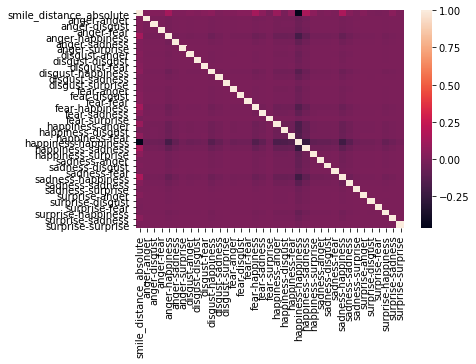

,smile_distance_absolute,anger-anger,anger-disgust,anger-fear,anger-happiness,anger-sadness,anger-surprise,disgust-anger,disgust-disgust,disgust-fear,disgust-happiness,disgust-sadness,disgust-surprise,fear-anger,fear-disgust,fear-fear,fear-happiness,fear-sadness,fear-surprise,happiness-anger,happiness-disgust,happiness-fear,happiness-happiness,happiness-sadness,happiness-surprise,sadness-anger,sadness-disgust,sadness-fear,sadness-happiness,sadness-sadness,sadness-surprise,surprise-anger,surprise-disgust,surprise-fear,surprise-happiness,surprise-sadness,surprise-surprise
smile_distance_absolute,1,0.0227925,0.0214585,0.0191114,0.13338,0.0102692,0.00883535,0.0239618,0.0127663,0.0294888,0.0505304,0.00248214,0.0149866,0.0167921,0.0339283,0.034236,0.136016,0.0471808,-0.0149226,0.0939518,-0.0148156,0.0585275,-0.462529,0.146116,0.0490183,-0.00411879,0.0110624,-0.00504202,0.159441,0.0239855,-8.39833e-05,0.0263181,-0.00916619,-0.0122513,-0.00817497,0.0406309,-0.00424985
anger-anger,0.0227925,1,-0.00622365,-0.00702641,-0.0223665,-0.00997132,-0.00459082,-0.00663688,-0.00530363,-0.00439484,-0.0151503,-0.00892633,-0.00350415,-0.00689895,-0.00546753,-0.00546753,-0.0170765,-0.0112486,-0.00374655,-0.0195407,-0.0188855,-0.0172424,-0.0614756,-0.0288593,-0.0107548,-0.00988067,-0.00978922,-0.00739599,-0.0247413,-0.0135348,-0.00562673,-0.00439484,-0.00459082,-0.00296082,-0.00862045,-0.00530363,-0.00264791
anger-disgust,0.0214585,-0.00622365,1,-0.00611465,-0.0194642,-0.00867742,-0.0039951,-0.00577566,-0.00461542,-0.00382455,-0.0131844,-0.00776803,-0.00304944,-0.00600372,-0.00475805,-0.00475805,-0.0148606,-0.00978895,-0.00326039,-0.0170051,-0.0164349,-0.015005,-0.0534984,-0.0251145,-0.00935921,-0.00859853,-0.00851894,-0.00643627,-0.0215308,-0.0117785,-0.00489659,-0.00382455,-0.0039951,-0.00257661,-0.00750184,-0.00461542,-0.00230431
anger-fear,0.0191114,-0.00702641,-0.00611465,1,-0.0219748,-0.00979669,-0.00451042,-0.00652064,-0.00521074,-0.00431787,-0.014885,-0.00877,-0.00344278,-0.00677812,-0.00537177,-0.00537177,-0.0167774,-0.0110516,-0.00368093,-0.0191985,-0.0185548,-0.0169405,-0.0603989,-0.0283539,-0.0105664,-0.00970762,-0.00961777,-0.00726645,-0.024308,-0.0132978,-0.00552819,-0.00431787,-0.00451042,-0.00290896,-0.00846948,-0.00521074,-0.00260154
anger-happiness,0.13338,-0.0223665,-0.0194642,-0.0219748,1,-0.0311849,-0.0143576,-0.0207565,-0.0165869,-0.0137447,-0.047382,-0.0279167,-0.0109591,-0.0215761,-0.0170994,-0.0170994,-0.053406,-0.0351795,-0.0117172,-0.0611127,-0.0590637,-0.053925,-0.192262,-0.0902563,-0.0336351,-0.0309013,-0.0306153,-0.0231306,-0.0773772,-0.0423296,-0.0175973,-0.0137447,-0.0143576,-0.00925982,-0.0269601,-0.0165869,-0.00828122
anger-sadness,0.0102692,-0.00997132,-0.00867742,-0.00979669,-0.0311849,1,-0.00640083,-0.00925358,-0.00739467,-0.00612757,-0.0211236,-0.0124457,-0.00488571,-0.00961897,-0.00762319,-0.00762319,-0.0238092,-0.0156835,-0.00522369,-0.027245,-0.0263315,-0.0240406,-0.0857133,-0.0402376,-0.014995,-0.0137763,-0.0136488,-0.010312,-0.0344959,-0.0188712,-0.00784516,-0.00612757,-0.00640083,-0.00412817,-0.0120192,-0.00739467,-0.00369189
anger-surprise,0.00883535,-0.00459082,-0.0039951,-0.00451042,-0.0143576,-0.00640083,1,-0.00426037,-0.00340452,-0.00282115,-0.00972536,-0.00573002,-0.00224939,-0.0044286,-0.00350973,-0.00350973,-0.0109618,-0.00722073,-0.002405,-0.0125437,-0.0121231,-0.0110683,-0.0394626,-0.0185255,-0.00690374,-0.00634263,-0.00628393,-0.00474766,-0.015882,-0.00868833,-0.00361193,-0.00282115,-0.00294695,-0.00190062,-0.00553367,-0.00340452,-0.00169976
disgust-anger,0.0239618,-0.00663688,-0.00577566,-0.00652064,-0.0207565,-0.00925358,-0.00426037,1,-0.00492187,-0.00407849,-0.0140598,-0.0082838,-0.00325191,-0.00640236,-0.00507397,-0.00507397,-0.0158473,-0.0104389,-0.00347687,-0.0181342,-0.0175262,-0.0160013,-0.0570505,-0.026782,-0.00998063,-0.00916945,-0.00908458,-0.00686362,-0.0229604,-0.0125606,-0.00522171,-0.00407849,-0.00426037,-0.0027477,-0.00799994,-0.00492187,-0.00245731
disgust-disgust,0.0127663,-0.005

                       cols       vif
0   smile_distance_absolute  1.325126
1               anger-anger  1.012968
2             anger-disgust  1.010211
3                anger-fear  1.011693
4           anger-happiness  1.171932
5             anger-sadness  1.017864
6            anger-surprise  1.004435
7             disgust-anger  1.011872
8           disgust-disgust  1.006374
9              disgust-fear  1.007732
10        disgust-happiness  1.058012
11          disgust-sadness  1.012573
12         disgust-surprise  1.003641
13               fear-anger  1.010800
14             fear-disgust  1.011267
15                fear-fear  1.011343
16           fear-happiness  1.129279
17             fear-sadness  1.036525
18            fear-surprise  1.000836
19          happiness-anger  1.115447
20        happiness-disgust  1.044216
21           happiness-fear  1.075085
22      happiness-happiness  1.032952
23        happiness-sadness  1.245468
24       happiness-surprise  1.035091
25          

In [854]:
analysis.test_features(shared_emotion_X, shared_emotion_Y, vif_thresh=10)

In [864]:
from pygam import LogisticGAM
gam = LogisticGAM().fit(full_emotion_X, full_emotion_Y)


/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pygam/pygam.py:1522: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pygam/pygam.py:1523: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll


In [551]:
from pygam import LogisticGAM
gam = LogisticGAM().fit(full_emotion_X, full_emotion_Y)


/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pygam/pygam.py:1522: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pygam/pygam.py:1523: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll


In [865]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.8998
Link Function:                        LogitLink Log Likelihood:                                       -inf
Number of Samples:                         5398 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.1148
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0069
Feature Function   Data Type      Num